In [1]:
import sqlite3
from pathlib import Path
import os
import pandas as pd
import re
from sklearn.preprocessing import PowerTransformer, StandardScaler

In [2]:
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]

In [3]:
db_path = PROJECT_ROOT / "data" / "all_data.db"
db = sqlite3.connect(db_path)

# Loading data

In [4]:
df_grd = pd.read_sql_query("SELECT * FROM GRD", db)
df_meteo_daily = pd.read_sql_query("SELECT * FROM Weather", db)

In [5]:
df_grd_monthly = df_grd[(df_grd["GRD"] == "SRM") & (df_grd["Class"] != "Total")].drop(columns = ["GRD", "type_d_heurs"])

In [6]:
df_grd_monthly.loc[df_grd_monthly["Class"] == "MT", "Activity"] = df_grd_monthly.loc[df_grd_monthly["Class"] == "MT", "Activity"].replace("Administratif", "Administratif_mt")

In [7]:
df_meteo_monthly = (
    df_meteo_daily
    .groupby(["Region", "Year", "Month"], as_index=False)
    .agg({
        "apparent_temperature_mean": "mean",
        "apparent_temperature_max": "mean",
        "apparent_temperature_min": "mean",
        "precipitation_sum": "sum",
        "et0_fao_evapotranspiration_sum": "sum"
    })
)

> there is no null values in the data

## 2013 to 2023 and yearly agg

In [8]:
# keep only data between 2013 and 2023
df_meteo_monthly = df_meteo_monthly[(df_meteo_monthly["Year"] >= 2013) & (df_meteo_monthly["Year"] <= 2023)]
df_grd_monthly = df_grd_monthly[(df_grd_monthly["Year"] >= 2013) & (df_grd_monthly["Year"] <= 2023)]

In [9]:
# I want to get the yearly versions
df_grd_yearly = (
    df_grd_monthly
    .groupby(["Region", "Year", "Class", "Activity"], as_index=False)
    .agg({
        "Consommation_Kwh": "sum",
        "Nbr Clients": "sum",
    })
)
df_meteo_yearly = (
    df_meteo_monthly
    .groupby(["Region", "Year"], as_index=False)
    .agg({
        "apparent_temperature_mean": "mean",
        "apparent_temperature_max": "mean",
        "apparent_temperature_min": "mean",
        "precipitation_sum": "sum",
        "et0_fao_evapotranspiration_sum": "sum"
    })
)

## 2020

In [10]:
# function to drop rows corresponding to year 2020
def drop_year_2020(df, year_column="Year"):
    return df[df[year_column] != 2020]

In [11]:
# apply drop_year_2020 to all dfs even the monthly
df_grd_yearly = drop_year_2020(df_grd_yearly, "Year")
df_meteo_yearly = drop_year_2020(df_meteo_yearly, "Year")
df_grd_monthly = drop_year_2020(df_grd_monthly, "Year")
df_meteo_monthly = drop_year_2020(df_meteo_monthly, "Year")

# Negative and 0 values

In [12]:
# utility function to drop <= 0 in one or multiple columns from a df
def drop_negative_or_zero_rows(df, column_names, include_zero=False):
    # Convert single column name to list for uniform processing
    if isinstance(column_names, str):
        column_names = [column_names]
    
    # Create mask: True for rows where ALL columns meet the condition
    mask = True
    for col in column_names:
        if col in df.columns:
            if include_zero:
                mask = mask & (df[col] >= 0)  # Keep zeros, drop negatives
            else:
                mask = mask & (df[col] > 0)   # Drop both zeros and negatives
    
    return df[mask]

In [13]:
# utility function that print columns that have values <=0
def print_negative_or_zero_columns(df):
    for column in df.select_dtypes(include=['number']).columns:
        if (df[column] <= 0).any():
            print(f"Column '{column}' has values <= 0")

In [14]:
print_negative_or_zero_columns(df_grd_monthly)

Column 'Consommation_Kwh' has values <= 0


In [ ]:
df_meteo_monthly[df_meteo_monthly["precipitation_sum"] <= 0]["precipitation_sum"].sum()

In [ ]:
df_grd_monthly[df_grd_monthly["Consommation_Kwh"] <= 0]

> grd (monthly) have some < 0 in 'Consommation_Kwh'

> meteo (monthly) have some negative values in 'apparent_temperature_min' and 0 values in 'precipitation_sum'

In [14]:
df_grd_monthly = drop_negative_or_zero_rows(df_grd_monthly, "Consommation_Kwh")

> removed the negatives values in 'Consommation_Kwh'

In [15]:
FEATURES = [
    "apparent_temperature_mean",
    "apparent_temperature_max",
    "apparent_temperature_min",
    "precipitation_sum",
    "et0_fao_evapotranspiration_sum",
]

# Utils

In [16]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
def print_results(results):
    """
    Prints a formatted summary of the regression analysis results.
    """
    print(f"--- Results for {results['Region']} - {results['Activity']} ({results['Frequency']}) ---")
    print(f"Test Year: {results['Test_Year']}")
    print(f"RMSE: {results['RMSE']:.2f}")
    print(f"MAE: {results['MAE']:.2f}")
    print(f"R2: {results['R2']:.4f} (Adj: {results['Adj_R2']:.4f})")
    print(f"F-statistic: {results['F_statistic']:.2f} (Prob: {results['Prob_F_statistic']:.4f})")
    print(f"AIC: {results['AIC']:.2f} | BIC: {results['BIC']:.2f}")
    print(f"Log-Likelihood: {results['Log_Likelihood']:.2f}")
    print(f"Condition Number: {results['Condition_Number']:.2f}")
    print(f"Durbin-Watson: {results['Durbin_Watson']:.2f}")
    print(f"Jarque-Bera: {results['Jarque_Bera']:.2f} (Prob: {results['Prob_Jarque_Bera']:.4f})")
    print("-" * 30)
    
    if 'Coefficients_Stats' in results:
        features = list(results['Coefficients_Stats'].keys())
        max_len = max([len(str(f)) for f in features]) if features else 10
        max_len = max(max_len, 7) # Ensure at least 'Feature' length
        
        header = f"{'Feature':<{max_len}} | {'Coef':>10} | {'P-value':>10} | {'Std Err':>10} | {'t-val':>10} | {'[0.025':>10} {'0.975]':>10}"
        print(header)
        print("-" * len(header))
        for feature, stats in results['Coefficients_Stats'].items():
            print(f"{str(feature):<{max_len}} | {stats['coef']:10.4f} | {stats['p_value']:10.4f} | {stats['std_err']:10.4f} | {stats['t_value']:10.4f} | {stats['conf_int_lower']:10.4f} {stats['conf_int_upper']:10.4f}")
    print("-" * 30)

In [18]:
def run_analysis(freq, df_grd, df_meteo, region, activity, features = FEATURES,
                 transformer_x=None, transformer_y=None,
                 results_list=None, verbose=False, fit_intercept=True, use_lasso=None, lasso_alpha=1.0, target = 'Consommation_Kwh'):
    """
    Run regression analysis with optional regularization.
    
    Parameters:
    -----------
    use_lasso : float or None, optional
        Controls regularization type:
        - None: Standard OLS (no regularization)
        - 0.0: Ridge regression (L2 penalty only)
        - 1.0: Lasso regression (L1 penalty only)
        - Between 0 and 1: Elastic Net (combination of L1 and L2)
    lasso_alpha : float, optional
        Regularization strength. Higher values mean more regularization. Default is 1.0.
    """
    if freq == "monthly":
        if "Month" not in df_grd.columns or "Month" not in df_meteo.columns:
            raise ValueError("Both dataframes must contain a 'Month' column for monthly frequency analysis.")
        
    
    df_grd = df_grd.copy()
    df_meteo = df_meteo.copy()

    df_grd_region = df_grd[(df_grd["Region"] == region) & (df_grd["Activity"] == activity)]
    df_meteo_region = df_meteo[df_meteo["Region"] == region]

    df_full = pd.merge(
        df_grd_region,
        df_meteo_region,
        on=["Year"] if freq == "yearly" else ["Year", "Month"],
        how="inner"
    )

    if df_full.empty:
        if verbose:
            print(f"No data available for Region: {region}, Activity: {activity}")
        return None

    X = df_full[features]
    y = df_full[target]

    # Split: take the last year as test
    last_year = df_full['Year'].max()
    
    # Ensure we have enough data to split
    if len(df_full['Year'].unique()) < 2:
        if verbose:
            print(f"Not enough years for split for Region: {region}, Activity: {activity}")
        return None

    X_train = X[df_full['Year'] < last_year].copy()
    y_train = y[df_full['Year'] < last_year].copy()
    X_test = X[df_full['Year'] == last_year].copy()
    y_test = y[df_full['Year'] == last_year].copy()  # Keep original scale for validation

    if X_train.empty or X_test.empty:
        if verbose:
            print(f"Empty train or test set for Region: {region}, Activity: {activity}")
        return None

    # --- HANDLE X TRANSFORMATION ---
    if transformer_x:
        # Fit on Train, Transform Train & Test
        X_train_np = transformer_x.fit_transform(X_train)
        X_test_np = transformer_x.transform(X_test)
        
        # CRITICAL: Reconstruct DataFrame to keep column names for Statsmodels
        # Some transformers (like PolynomialFeatures) change feature count/names
        if hasattr(transformer_x, 'get_feature_names_out'):
            new_features = transformer_x.get_feature_names_out(features)
        else:
            new_features = features  # Assuming 1-to-1 mapping if method doesn't exist

        X_train = pd.DataFrame(X_train_np, columns=new_features, index=X_train.index)
        X_test = pd.DataFrame(X_test_np, columns=new_features, index=X_test.index)

    # --- HANDLE Y TRANSFORMATION ---
    y_train_modeling = y_train  # This is what goes into OLS
    
    if transformer_y:
        # Transformers expect 2D array (n_samples, 1)
        y_train_2d = y_train.values.reshape(-1, 1)
        
        # Fit & Transform
        y_train_scaled = transformer_y.fit_transform(y_train_2d)
        
        # Flatten back to 1D Series for OLS
        y_train_modeling = pd.Series(y_train_scaled.flatten(), index=y_train.index)

    # Train using statsmodels OLS (with optional regularization)
    # Add constant for intercept (statsmodels doesn't add it by default)
    # Add constant AFTER transformation
    if fit_intercept:
        X_train_sm = sm.add_constant(X_train)
        X_test_sm = sm.add_constant(X_test, has_constant='add')
    else:
        X_train_sm = X_train
        X_test_sm = X_test

    try:
        if use_lasso is not None:
            # Determine regularization type based on use_lasso value
            if use_lasso == 0.0:
                reg_type = "Ridge"
            elif use_lasso == 1.0:
                reg_type = "Lasso"
            else:
                reg_type = "Elastic Net"
            
            # Use statsmodels regularized fit with elastic net
            # L1_wt controls the mix: 0=Ridge, 1=Lasso, between=Elastic Net
            model = sm.OLS(y_train_modeling, X_train_sm).fit_regularized(
                method='elastic_net',
                alpha=lasso_alpha,
                L1_wt=use_lasso,  # Controls L1 vs L2 penalty
                refit=True
            )
        else:
            # Standard OLS
            reg_type = "OLS"
            model = sm.OLS(y_train_modeling, X_train_sm).fit()
    except Exception as e:
        if verbose:
            print(f"Error fitting model for {region} - {activity}: {e}")
        return None

    # --- PREDICTION & INVERSE TRANSFORM ---
    y_pred_raw = model.predict(X_test_sm)
    
    if transformer_y:
        # Inverse transform the predictions to get back to Kwh
        y_pred_final = transformer_y.inverse_transform(y_pred_raw.values.reshape(-1, 1)).flatten()
    else:
        y_pred_final = y_pred_raw

    mse = mean_squared_error(y_test, y_pred_final)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred_final)
    
    # Gather stats
    results_dict = {
        "Region": region,
        "Activity": activity,
        "Frequency": freq,
        "Test_Year": last_year,
        "RMSE": rmse,
        "MAE": mae,
        "R2": model.rsquared,
        "Adj_R2": model.rsquared_adj,
        "F_statistic": model.fvalue,
        "Prob_F_statistic": model.f_pvalue,
        "AIC": model.aic,
        "BIC": model.bic,
        "Log_Likelihood": model.llf,
        "Condition_Number": model.condition_number,
        # Residual stats
        "Durbin_Watson": sm.stats.stattools.durbin_watson(model.resid),
        "Jarque_Bera": sm.stats.stattools.jarque_bera(model.resid)[0],
        "Prob_Jarque_Bera": sm.stats.stattools.jarque_bera(model.resid)[1],
        "Skew": sm.stats.stattools.jarque_bera(model.resid)[2],
        "Kurtosis": sm.stats.stattools.jarque_bera(model.resid)[3],
        "Transformer_Y": str(type(transformer_y).__name__) if transformer_y else None,
        "Transformer_X": str(type(transformer_x).__name__) if transformer_x else None,
        "Regularization_Type": reg_type,
        "L1_Weight": use_lasso if use_lasso is not None else None,
        "Regularization_Alpha": lasso_alpha if use_lasso is not None else None,
        "Coefficients_Stats": {}
    }

    # Coefficient specific stats
    # Handle both pandas Series (OLS) and numpy array (regularized) params
    params = model.params if isinstance(model.params, pd.Series) else pd.Series(model.params, index=X_train_sm.columns)
    
    # Get confidence intervals if available
    conf_int_lower = None
    conf_int_upper = None
    if hasattr(model, 'conf_int') and callable(model.conf_int):
        try:
            ci = model.conf_int()
            if isinstance(ci, pd.DataFrame):
                conf_int_lower = ci[0]
                conf_int_upper = ci[1]
            elif isinstance(ci, np.ndarray):
                conf_int_lower = pd.Series(ci[:, 0], index=X_train_sm.columns)
                conf_int_upper = pd.Series(ci[:, 1], index=X_train_sm.columns)
        except:
            pass
    
    # Calculate unscaled coefficients if StandardScaler was used
    unscaled_params = None
    if transformer_x and isinstance(transformer_x, StandardScaler) and transformer_y and isinstance(transformer_y, StandardScaler):
        # Get the standard deviations and means from the transformers
        std_y = transformer_y.scale_[0]  # Target has shape (n_samples, 1), so scale_[0]
        std_X = transformer_x.scale_  # Features standard deviations
        mean_y = transformer_y.mean_[0]
        mean_X = transformer_x.mean_
        
        # Create unscaled coefficients
        unscaled_params = params.copy()
        
        # First pass: unscale all feature coefficients
        for feature in X_train_sm.columns:
            if feature != 'const':
                # For regular features: β_i_unscaled = β_i_scaled × (std_y / std_x_i)
                feature_idx = list(X_train_sm.columns).index(feature)
                actual_feature_idx = feature_idx - 1 if fit_intercept else feature_idx
                if actual_feature_idx < len(std_X):
                    unscaled_params[feature] = params[feature] * std_y / std_X[actual_feature_idx]
        
        # Second pass: calculate the unscaled intercept
        # Sum of (unscaled_coef × mean_feature)
        sum_term = sum([
            unscaled_params[feat] * mean_X[i]
            for i, feat in enumerate(X_train_sm.columns) if feat != 'const'
        ])
        
        if fit_intercept and 'const' in X_train_sm.columns:
            # When fit_intercept=True: β₀_unscaled = β₀_scaled × std_y + mean_y - Σ(β_i_unscaled × mean_x_i)
            beta_0_scaled = params['const']
            unscaled_params['const'] = beta_0_scaled * std_y + mean_y - sum_term
        else:
            # When fit_intercept=False: implicit intercept created by unscaling
            # β₀_unscaled = mean_y - Σ(β_i_unscaled × mean_x_i)
            unscaled_params['implicit_intercept'] = mean_y - sum_term
    
    for feature in X_train_sm.columns:
        coef_val = params[feature]
        unscaled_coef_val = unscaled_params[feature] if unscaled_params is not None and feature in unscaled_params else None
        
        results_dict["Coefficients_Stats"][feature] = {
            "coef": coef_val,
            "coef_unscaled": unscaled_coef_val,
            "std_err": model.bse[feature] if hasattr(model, 'bse') and isinstance(model.bse, pd.Series) else None,
            "t_value": model.tvalues[feature] if hasattr(model, 'tvalues') and isinstance(model.tvalues, pd.Series) else None,
            "p_value": model.pvalues[feature] if hasattr(model, 'pvalues') and isinstance(model.pvalues, pd.Series) else None,
            "conf_int_lower": conf_int_lower[feature] if conf_int_lower is not None else None,
            "conf_int_upper": conf_int_upper[feature] if conf_int_upper is not None else None,
            "is_zero": abs(coef_val) < 1e-10  # Flag coefficients zeroed out by regularization
        }
        # Flatten for DataFrame friendly format
        results_dict[f"coef_{feature}"] = coef_val
        results_dict[f"coef_unscaled_{feature}"] = unscaled_coef_val
        results_dict[f"pval_{feature}"] = model.pvalues[feature] if hasattr(model, 'pvalues') and isinstance(model.pvalues, pd.Series) else None
        results_dict[f"zero_{feature}"] = abs(coef_val) < 1e-10
        results_dict["implicit_intercept"] = unscaled_params.get("implicit_intercept") if unscaled_params is not None else None
        
        

    if verbose:
        print_results(results_dict)

    if results_list is not None:
        results_list.append(results_dict)

    return results_dict

In [19]:
def run_full_analysis(
    df_grd_yearly,
    df_grd_monthly,
    df_meteo_yearly,
    df_meteo_monthly,
    output_folder,
    features = FEATURES,
    transformer_x=None,
    transformer_y=None,
    fit_intercept=True,
    frequencies=["yearly", "monthly"],
    use_lasso=None,
    lasso_alpha=1.0,
    target = 'Consommation_Kwh'
):
    """
    Run regression analysis for specified frequencies.
    
    Parameters:
    -----------
    frequencies : list of str, optional
        Which frequencies to run. Options: ["yearly"], ["monthly"], or ["yearly", "monthly"] (default)
    use_lasso : float or None, optional
        Controls regularization type:
        - None: Standard OLS (no regularization)
        - 0.0: Ridge regression (L2 penalty only)
        - 1.0: Lasso regression (L1 penalty only)
        - Between 0 and 1: Elastic Net (combination of L1 and L2)
    lasso_alpha : float, optional
        Regularization strength (higher = more features zeroed out). Default is 1.0.
    """
    results = []

    # Get unique regions and activities
    regions = df_grd_yearly["Region"].unique()
    activities = df_grd_yearly["Activity"].unique()

    print(
        f"Starting analysis for {len(regions)} regions and {len(activities)} activities..."
    )
    print(f"Frequencies: {', '.join(frequencies)}")
    
    # Determine regression type description
    if use_lasso is None:
        reg_desc = "OLS"
    elif use_lasso == 0.0:
        reg_desc = f"Ridge (alpha={lasso_alpha})"
    elif use_lasso == 1.0:
        reg_desc = f"Lasso (alpha={lasso_alpha})"
    else:
        reg_desc = f"Elastic Net (L1_wt={use_lasso}, alpha={lasso_alpha})"
    
    print(f"Regression Type: {reg_desc}")
    if transformer_x:
        print(f"X Transformer: {type(transformer_x).__name__}")
    if transformer_y:
        print(f"Y Transformer: {type(transformer_y).__name__}")

    # 1. Yearly Analysis Loop
    if "yearly" in frequencies:
        print("Processing Yearly data...")
        for region in regions:
            for activity in activities:
                # Create fresh transformer instances for each analysis
                tx = (
                    type(transformer_x)(**transformer_x.get_params())
                    if transformer_x
                    else None
                )
                ty = (
                    type(transformer_y)(**transformer_y.get_params())
                    if transformer_y
                    else None
                )

                run_analysis(
                    freq="yearly",
                    df_grd=df_grd_yearly,
                    df_meteo=df_meteo_yearly,
                    region=region,
                    activity=activity,
                    features=features,
                    transformer_x=tx,
                    transformer_y=ty,
                    results_list=results,
                    fit_intercept=fit_intercept,
                    use_lasso=use_lasso,
                    lasso_alpha=lasso_alpha,
                    target=target
                )

    # 2. Monthly Analysis Loop
    if "monthly" in frequencies:
        print("Processing Monthly data...")
        for region in regions:
            for activity in activities:
                # Create fresh transformer instances for each analysis
                tx = (
                    type(transformer_x)(**transformer_x.get_params())
                    if transformer_x
                    else None
                )
                ty = (
                    type(transformer_y)(**transformer_y.get_params())
                    if transformer_y
                    else None
                )

                run_analysis(
                    freq="monthly",
                    df_grd=df_grd_monthly,
                    df_meteo=df_meteo_monthly,
                    region=region,
                    activity=activity,
                    features=features,
                    transformer_x=tx,
                    transformer_y=ty,
                    results_list=results,
                    fit_intercept=fit_intercept,
                    use_lasso=use_lasso,
                    lasso_alpha=lasso_alpha,
                    target=target
                )

    # Convert to DataFrame
    df_results = pd.DataFrame(results)

    # Save to CSV
    output_file = PROJECT_ROOT / output_folder / "regression_analysis_results.csv"
    # Ensure the directory exists
    output_file.parent.mkdir(parents=True, exist_ok=True)

    df_results.to_csv(output_file, index=False, encoding='utf-8-sig')

    print(f"Done! Results saved to: {output_file}")
    print(f"Total records: {len(df_results)}")


    return results

In [20]:
def create_analysis_report(results_list, output_folder, features=FEATURES, verbose=True):
    """
    Creates a comprehensive visual report from the regression analysis results.
    
    Parameters:
    -----------
    results_list : list
        List of result dictionaries from run_analysis
    output_folder : Path or str
        Folder name where the report will be saved (inside PROJECT_ROOT)
    verbose : bool, optional
        If True, prints the summary statistics to console. Default is True.
    """
    if not results_list:
        msg = "No results to analyze!"
        if verbose:
            print(msg)
        return
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(results_list)
    
    # Remove None values if any
    df = df.dropna(subset=['R2'])
    
    if df.empty:
        msg = "No valid results to analyze!"
        if verbose:
            print(msg)
        return
    
    # Create output directory
    output_dir = PROJECT_ROOT / output_folder
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Set up the style
    sns.set_style("whitegrid")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. Feature Significance Count (p-value < 0.05) - Split by Frequency
    ax1 = plt.subplot(4, 3, 1)
    
    # Calculate significance for yearly and monthly separately
    df_yearly = df[df['Frequency'] == 'yearly']
    df_monthly = df[df['Frequency'] == 'monthly']
    
    significance_counts_yearly = {}
    significance_counts_monthly = {}
    
    for feature in features:
        pval_col = f'pval_{feature}'
        if pval_col in df.columns:
            significance_counts_yearly[feature] = (df_yearly[pval_col] < 0.05).sum() if len(df_yearly) > 0 else 0
            significance_counts_monthly[feature] = (df_monthly[pval_col] < 0.05).sum() if len(df_monthly) > 0 else 0
    
    if significance_counts_yearly or significance_counts_monthly:
        x = range(len(features))
        width = 0.35
        plt.barh([i - width/2 for i in x], [significance_counts_yearly.get(f, 0) for f in features], 
                 width, label='Yearly', color='steelblue')
        plt.barh([i + width/2 for i in x], [significance_counts_monthly.get(f, 0) for f in features], 
                 width, label='Monthly', color='lightcoral')
        plt.yticks(x, features)
        plt.xlabel('Count (p < 0.05)')
        plt.title('Feature Significance Count\n(p-value < 0.05)')
        plt.legend()
    
    # 2. R² Distribution
    ax2 = plt.subplot(4, 3, 2)
    plt.hist(df['R2'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(df['R2'].mean(), color='red', linestyle='--', label=f'Mean: {df["R2"].mean():.3f}')
    plt.axvline(df['R2'].median(), color='green', linestyle='--', label=f'Median: {df["R2"].median():.3f}')
    plt.xlabel('R²')
    plt.ylabel('Frequency')
    plt.title('Distribution of R² Scores')
    plt.legend()
    
    # 3. R² by Frequency
    ax3 = plt.subplot(4, 3, 3)
    df.boxplot(column='R2', by='Frequency', ax=ax3)
    plt.ylabel('R²')
    plt.title('R² by Frequency (Yearly vs Monthly)')
    plt.suptitle('')
    
    # 4. RMSE Distribution
    ax4 = plt.subplot(4, 3, 4)
    plt.hist(df['RMSE'], bins=30, color='coral', edgecolor='black', alpha=0.7)
    plt.axvline(df['RMSE'].mean(), color='red', linestyle='--', label=f'Mean: {df["RMSE"].mean():.0f}')
    plt.axvline(df['RMSE'].median(), color='green', linestyle='--', label=f'Median: {df["RMSE"].median():.0f}')
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.title('Distribution of RMSE')
    plt.legend()
    
    # 5. Top 10 Best Models (by R²)
    ax5 = plt.subplot(4, 3, 5)
    top_10 = df.nlargest(10, 'R2')[['Region', 'Activity', 'Frequency', 'R2']].copy()
    top_10['Label'] = top_10['Region'].str[:15] + '\n' + top_10['Activity'].str[:15]
    colors = ['green' if f == 'yearly' else 'blue' for f in top_10['Frequency']]
    plt.barh(range(len(top_10)), top_10['R2'], color=colors)
    plt.yticks(range(len(top_10)), top_10['Label'], fontsize=8)
    plt.xlabel('R²')
    plt.title('Top 10 Models by R²')
    plt.gca().invert_yaxis()
    
    # 6. Bottom 10 Worst Models (by R²)
    ax6 = plt.subplot(4, 3, 6)
    bottom_10 = df.nsmallest(10, 'R2')[['Region', 'Activity', 'Frequency', 'R2']].copy()
    bottom_10['Label'] = bottom_10['Region'].str[:15] + '\n' + bottom_10['Activity'].str[:15]
    colors = ['green' if f == 'yearly' else 'blue' for f in bottom_10['Frequency']]
    plt.barh(range(len(bottom_10)), bottom_10['R2'], color=colors)
    plt.yticks(range(len(bottom_10)), bottom_10['Label'], fontsize=8)
    plt.xlabel('R²')
    plt.title('Bottom 10 Models by R²')
    plt.gca().invert_yaxis()
    
    # 7. F-statistic Distribution
    ax7 = plt.subplot(4, 3, 7)
    # Filter out extreme values for better visualization
    f_stats_filtered = df[df['F_statistic'] < df['F_statistic'].quantile(0.95)]['F_statistic']
    plt.hist(f_stats_filtered, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.xlabel('F-statistic')
    plt.ylabel('Frequency')
    plt.title('Distribution of F-statistic (95th percentile)')
    
    # 8. Model Performance by Region
    ax8 = plt.subplot(4, 3, 8)
    region_perf = df.groupby('Region')['R2'].mean().sort_values(ascending=True)
    plt.barh(region_perf.index, region_perf.values, color='mediumpurple')
    plt.xlabel('Average R²')
    plt.title('Average R² by Region')
    
    # 9. Model Performance by Activity
    ax9 = plt.subplot(4, 3, 9)
    activity_perf = df.groupby('Activity')['R2'].mean().sort_values(ascending=False).head(15)
    plt.barh(range(len(activity_perf)), activity_perf.values, color='orange')
    plt.yticks(range(len(activity_perf)), activity_perf.index, fontsize=8)
    plt.xlabel('Average R²')
    plt.title('Top 15 Activities by Average R²')
    plt.gca().invert_yaxis()
    
    # 10. Coefficient Distribution for each feature
    ax10 = plt.subplot(4, 3, 10)
    coef_data = []
    for feature in features:
        coef_col = f'coef_{feature}'
        if coef_col in df.columns:
            coef_data.append(df[coef_col].dropna())
    
    if coef_data:
        plt.boxplot(coef_data, labels=[f[:20] for f in features], vert=True)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.ylabel('Coefficient Value')
        plt.title('Distribution of Coefficients by Feature')
        plt.grid(axis='y', alpha=0.3)
    
    # 11. AIC vs BIC
    ax11 = plt.subplot(4, 3, 11)
    plt.scatter(df['AIC'], df['BIC'], alpha=0.5, c=df['R2'], cmap='viridis')
    plt.xlabel('AIC')
    plt.ylabel('BIC')
    plt.title('AIC vs BIC (colored by R²)')
    plt.colorbar(label='R²')
    
    # 12. Durbin-Watson Distribution
    ax12 = plt.subplot(4, 3, 12)
    plt.hist(df['Durbin_Watson'], bins=30, color='salmon', edgecolor='black', alpha=0.7)
    plt.axvline(2.0, color='red', linestyle='--', label='Ideal (2.0)')
    plt.xlabel('Durbin-Watson Statistic')
    plt.ylabel('Frequency')
    plt.title('Durbin-Watson Distribution\n(Autocorrelation Test)')
    plt.legend()
    
    plt.tight_layout()
    
    # Save the image
    img_path = output_dir / "regression_analysis_report.png"
    plt.savefig(img_path, dpi=300, bbox_inches='tight')
    if verbose:
        print(f"Report image saved to: {img_path}")
    
    plt.show()
    
    # Generate Summary Statistics Text
    summary_lines = []
    summary_lines.append("="*60)
    summary_lines.append("REGRESSION ANALYSIS SUMMARY REPORT")
    summary_lines.append("="*60)
    summary_lines.append(f"Total Models Analyzed: {len(df)}")
    summary_lines.append(f"Yearly Models: {len(df_yearly)}")
    summary_lines.append(f"Monthly Models: {len(df_monthly)}")
    
    summary_lines.append("\nR² Statistics:")
    summary_lines.append(f"  Mean: {df['R2'].mean():.4f}")
    summary_lines.append(f"  Median: {df['R2'].median():.4f}")
    summary_lines.append(f"  Std Dev: {df['R2'].std():.4f}")
    summary_lines.append(f"  Min: {df['R2'].min():.4f}")
    summary_lines.append(f"  Max: {df['R2'].max():.4f}")
    summary_lines.append(f"\nModels with R² > 0.7: {len(df[df['R2'] > 0.7])} ({len(df[df['R2'] > 0.7])/len(df)*100:.1f}%)")
    summary_lines.append(f"Models with R² > 0.5: {len(df[df['R2'] > 0.5])} ({len(df[df['R2'] > 0.5])/len(df)*100:.1f}%)")
    summary_lines.append(f"Models with R² < 0.3: {len(df[df['R2'] < 0.3])} ({len(df[df['R2'] < 0.3])/len(df)*100:.1f}%)")
    
    summary_lines.append("\nRMSE Statistics:")
    summary_lines.append(f"  Mean: {df['RMSE'].mean():.2f}")
    summary_lines.append(f"  Median: {df['RMSE'].median():.2f}")
    summary_lines.append(f"  Std Dev: {df['RMSE'].std():.2f}")
    
    summary_lines.append("\nFeature Significance (p < 0.05):")
    summary_lines.append("\n  YEARLY Models:")
    total_yearly = len(df_yearly) if len(df_yearly) > 0 else 1
    for feature in features:
        count = significance_counts_yearly.get(feature, 0)
        percentage = (count / total_yearly) * 100
        summary_lines.append(f"    {feature}: {count} ({percentage:.1f}%)")
    
    summary_lines.append("\n  MONTHLY Models:")
    total_monthly = len(df_monthly) if len(df_monthly) > 0 else 1
    for feature in features:
        count = significance_counts_monthly.get(feature, 0)
        percentage = (count / total_monthly) * 100
        summary_lines.append(f"    {feature}: {count} ({percentage:.1f}%)")
    
    summary_lines.append("\n  OVERALL:")
    for feature in features:
        pval_col = f'pval_{feature}'
        if pval_col in df.columns:
            count = (df[pval_col] < 0.05).sum()
            percentage = (count / len(df)) * 100
            summary_lines.append(f"    {feature}: {count} ({percentage:.1f}%)")
    
    summary_lines.append("\nTop 5 Best Performing Combinations:")
    for idx, row in df.nlargest(5, 'R2').iterrows():
        summary_lines.append(f"  {row['Region']} - {row['Activity']} ({row['Frequency']}): R²={row['R2']:.4f}")
    
    summary_lines.append("\nTop 5 Worst Performing Combinations:")
    for idx, row in df.nsmallest(5, 'R2').iterrows():
        summary_lines.append(f"  {row['Region']} - {row['Activity']} ({row['Frequency']}): R²={row['R2']:.4f}")
    
    summary_lines.append("="*60)
    
    # Save summary to text file
    summary_text = "\n".join(summary_lines)
    text_path = output_dir / "regression_analysis_summary.txt"
    with open(text_path, 'w', encoding='utf-8') as f:
        f.write(summary_text)
    
    if verbose:
        print(f"Summary text saved to: {text_path}")
        print("\n" + summary_text)
    
    return summary_text

In [21]:
def plot_sensitivity_analysis(df_output, save_path=None, prefix = "coef_unscaled_"):
    """
    Creates comprehensive visualizations for sensitivity analysis results.
    
    Parameters:
    -----------
    df_output : pd.DataFrame
        DataFrame containing Region, Activity, RMSE, MAE, R2, and unscaled coefficients
    save_path : Path or str, optional
        Path to save the figure. If None, only displays the plot.
    """
    # Extract coefficient columns
    coef_cols = [col for col in df_output.columns if col.startswith(prefix)]
    feature_names = [col.replace(prefix, '') for col in coef_cols]
    
    # Create figure
    fig = plt.figure(figsize=(24, 18))
    
    # 1. Heatmap of coefficients by Region and Activity
    ax1 = plt.subplot(3, 4, 1)
    # Aggregate by activity (mean coefficients)
    activity_coefs = df_output.groupby('Activity')[coef_cols].mean()
    sns.heatmap(activity_coefs.T, cmap='RdBu_r', center=0, annot=False, 
                cbar_kws={'label': 'Unscaled Coefficient'}, ax=ax1)
    ax1.set_ylabel('Features')
    ax1.set_xlabel('Activity')
    ax1.set_title('Average Sensitivity by Activity')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=7)
    
    # 2. Coefficient distributions by feature
    ax2 = plt.subplot(3, 4, 2)
    coef_data = [df_output[col].dropna() for col in coef_cols]
    bp = ax2.boxplot(coef_data, labels=[f[:20] for f in feature_names], patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Unscaled Coefficient')
    ax2.set_title('Distribution of Sensitivity Coefficients')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. R² vs Average Absolute Sensitivity
    ax3 = plt.subplot(3, 4, 3)
    df_output['avg_abs_sensitivity'] = df_output[coef_cols].abs().mean(axis=1)
    scatter = ax3.scatter(df_output['avg_abs_sensitivity'], df_output['R2'], 
                         c=df_output['RMSE'], cmap='viridis', alpha=0.6, s=50)
    ax3.set_xlabel('Average Absolute Sensitivity')
    ax3.set_ylabel('R²')
    ax3.set_title('Model Performance vs Sensitivity')
    plt.colorbar(scatter, ax=ax3, label='RMSE')
    ax3.grid(alpha=0.3)
    
    # 4. Top 10 Most Sensitive Activities (by average absolute coefficient)
    ax4 = plt.subplot(3, 4, 4)
    activity_sensitivity = df_output.groupby('Activity')[coef_cols].apply(lambda x: x.abs().mean().mean())
    top_sensitive = activity_sensitivity.nlargest(10)
    ax4.barh(range(len(top_sensitive)), top_sensitive.values, color='coral')
    ax4.set_yticks(range(len(top_sensitive)))
    ax4.set_yticklabels(top_sensitive.index, fontsize=8)
    ax4.set_xlabel('Average Absolute Sensitivity')
    ax4.set_title('Top 10 Most Sensitive Activities')
    ax4.invert_yaxis()
    
    # 5-8. Individual feature coefficient distributions
    for idx, (col, feature) in enumerate(zip(coef_cols, feature_names), 5):
        ax = plt.subplot(3, 4, idx)
        ax.hist(df_output[col].dropna(), bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax.axvline(df_output[col].mean(), color='red', linestyle='--', 
                  label=f'Mean: {df_output[col].mean():.2e}')
        ax.axvline(df_output[col].median(), color='green', linestyle='--', 
                  label=f'Median: {df_output[col].median():.2e}')
        ax.axvline(0, color='black', linestyle='-', alpha=0.3)
        ax.set_xlabel('Coefficient Value')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{feature[:25]}\nSensitivity Distribution')
        ax.legend(fontsize=7)
        ax.grid(axis='y', alpha=0.3)
    
    # 9. Coefficient comparison across features (violin plot)
    ax9 = plt.subplot(3, 4, 9)
    coef_df_long = df_output[coef_cols].melt(var_name='Feature', value_name='Coefficient')
    coef_df_long['Feature'] = coef_df_long['Feature'].str.replace(prefix, '')
    sns.violinplot(data=coef_df_long, x='Feature', y='Coefficient', ax=ax9, palette='Set2')
    ax9.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    ax9.set_title('Coefficient Distribution by Feature')
    plt.setp(ax9.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax9.grid(axis='y', alpha=0.3)
    
    # 10. Regional sensitivity comparison
    ax10 = plt.subplot(3, 4, 10)
    region_sensitivity = df_output.groupby('Region')[coef_cols].apply(lambda x: x.abs().mean().mean())
    ax10.barh(region_sensitivity.index, region_sensitivity.values, color='mediumpurple')
    ax10.set_xlabel('Average Absolute Sensitivity')
    ax10.set_title('Average Sensitivity by Region')
    ax10.grid(axis='x', alpha=0.3)
    
    # 11. Model quality distribution
    ax11 = plt.subplot(3, 4, 11)
    ax11_twin = ax11.twinx()
    
    r2_counts, r2_bins, _ = ax11.hist(df_output['R2'], bins=25, color='steelblue', 
                                      alpha=0.6, label='R²', edgecolor='black')
    rmse_counts, rmse_bins, _ = ax11_twin.hist(df_output['RMSE'], bins=25, color='coral', 
                                               alpha=0.6, label='RMSE', edgecolor='black')
    
    ax11.set_xlabel('Value')
    ax11.set_ylabel('Frequency (R²)', color='steelblue')
    ax11_twin.set_ylabel('Frequency (RMSE)', color='coral')
    ax11.set_title('Model Quality Metrics Distribution')
    ax11.tick_params(axis='y', labelcolor='steelblue')
    ax11_twin.tick_params(axis='y', labelcolor='coral')
    
    # Add legends
    lines1, labels1 = ax11.get_legend_handles_labels()
    lines2, labels2 = ax11_twin.get_legend_handles_labels()
    ax11.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # 12. Correlation heatmap between coefficients
    ax12 = plt.subplot(3, 4, 12)
    coef_corr = df_output[coef_cols].corr()
    coef_corr.columns = [f[:20] for f in feature_names]
    coef_corr.index = [f[:20] for f in feature_names]
    sns.heatmap(coef_corr, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=ax12, fmt='.2f', cbar_kws={'label': 'Correlation'})
    ax12.set_title('Coefficient Correlations')
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("SENSITIVITY ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total Models: {len(df_output)}")
    print(f"\nModel Performance:")
    print(f"  R² - Mean: {df_output['R2'].mean():.4f}, Median: {df_output['R2'].median():.4f}")
    print(f"  RMSE - Mean: {df_output['RMSE'].mean():.2f}, Median: {df_output['RMSE'].median():.2f}")
    print(f"  MAE - Mean: {df_output['MAE'].mean():.2f}, Median: {df_output['MAE'].median():.2f}")
    
    print(f"\nCoefficient Statistics:")
    for col, feature in zip(coef_cols, feature_names):
        mean_val = df_output[col].mean()
        median_val = df_output[col].median()
        std_val = df_output[col].std()
        print(f"  {feature}:")
        print(f"    Mean: {mean_val:.4e}, Median: {median_val:.4e}, Std: {std_val:.4e}")
    
    print("="*60)

In [71]:
def simulate_meteo_corrections(df_predictions, df_sensitivity, meteo_features, 
                               actual_col='Consommation_Kwh', 
                               predicted_col='Predicted_Consommation_Kwh',
                               output_folder=None):
    """
    Simulate corrections to predictions based on meteorological data and sensitivity coefficients.
    
    This function uses the unscaled sensitivity coefficients to estimate how much the prediction
    error can be attributed to meteorological factors, and simulates corrected predictions.
    
    Parameters:
    -----------
    df_predictions : pd.DataFrame
        DataFrame with columns: Region, Activity, Consommation_Kwh (actual), 
        Predicted_Consommation_Kwh, and meteorological features
    df_sensitivity : pd.DataFrame
        DataFrame with sensitivity coefficients (from df_output_unscaled)
        Must have columns: Region, Activity, and coef_unscaled_{feature} for each meteo feature
    meteo_features : list
        List of meteorological feature names (without 'coef_unscaled_' prefix)
    actual_col : str
        Name of the actual consumption column
    predicted_col : str
        Name of the predicted consumption column
    output_folder : Path or str, optional
        Folder to save results and plots
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with original data plus simulated corrections and analysis
    """
    # Merge predictions with sensitivity coefficients
    df_merged = df_predictions.merge(
        df_sensitivity,
        on=['Region', 'Activity'],
        how='left'
    )
    
    # Calculate prediction error
    df_merged['Error'] = df_merged[actual_col] - df_merged[predicted_col]
    df_merged['Error_Pct'] = (df_merged['Error'] / df_merged[actual_col]) * 100
    
    # For each meteo feature, calculate its contribution to the error
    # Error contribution = sensitivity_coef * meteo_value
    meteo_contributions = {}
    for feature in meteo_features:
        coef_col = f'coef_unscaled_{feature}'
        if coef_col in df_merged.columns and feature in df_merged.columns:
            contribution = df_merged[coef_col] * df_merged[feature]
            df_merged[f'{feature}_contribution'] = contribution
            meteo_contributions[feature] = contribution
    
    # Add implicit intercept contribution if available
    # The implicit intercept represents the centering effect from StandardScaler
    # even when fit_intercept=False
    if 'implicit_intercept' in df_merged.columns:
        df_merged['implicit_intercept_contribution'] = df_merged['implicit_intercept']
        contribution_cols = [f'{f}_contribution' for f in meteo_features] + ['implicit_intercept_contribution']
    else:
        contribution_cols = [f'{f}_contribution' for f in meteo_features]
    
    # Calculate total meteorological contribution to error
    df_merged['Total_Meteo_Contribution'] = df_merged[contribution_cols].sum(axis=1)
    
    # Simulate corrected prediction by adjusting for meteo contribution
    df_merged['Predicted_Corrected'] = df_merged[predicted_col] + df_merged['Total_Meteo_Contribution']
    
    # Calculate corrected error
    df_merged['Error_Corrected'] = df_merged[actual_col] - df_merged['Predicted_Corrected']
    df_merged['Error_Corrected_Pct'] = (df_merged['Error_Corrected'] / df_merged[actual_col]) * 100
    
    
    # Calculate improvement metrics
    df_merged['RMSE_Original'] = df_merged['Error'] ** 2
    df_merged['RMSE_Corrected'] = df_merged['Error_Corrected'] ** 2
    df_merged['MAE_Original'] = df_merged['Error'].abs()
    df_merged['MAE_Corrected'] = df_merged['Error_Corrected'].abs()
    
    # Calculate percentage of error explained by meteorology
    df_merged['Meteo_Explained_Pct'] = (df_merged['Total_Meteo_Contribution'] / df_merged['Error']) * 100

    # Optional: Handle division by zero and extreme values
    df_merged['Meteo_Explained_Pct'] = df_merged['Meteo_Explained_Pct'].replace([np.inf, -np.inf], np.nan)
    df_merged['Meteo_Explained_Pct'] = df_merged['Meteo_Explained_Pct'].clip(-200, 200)
    
    # Summary statistics
    print("\n" + "="*70)
    print("METEOROLOGICAL CORRECTION SIMULATION SUMMARY")
    print("="*70)
    print(f"Total Predictions: {len(df_merged)}")
    print(f"\nOriginal Predictions:")
    print(f"  RMSE: {np.sqrt(df_merged['RMSE_Original'].mean()):.2f}")
    print(f"  MAE: {df_merged['MAE_Original'].mean():.2f}")
    print(f"  Mean Error: {df_merged['Error'].mean():.2f}")
    print(f"  Mean Error %: {df_merged['Error_Pct'].mean():.2f}%")
    
    print(f"\nCorrected Predictions (with meteo adjustment):")
    print(f"  RMSE: {np.sqrt(df_merged['RMSE_Corrected'].mean()):.2f}")
    print(f"  MAE: {df_merged['MAE_Corrected'].mean():.2f}")
    print(f"  Mean Error: {df_merged['Error_Corrected'].mean():.2f}")
    print(f"  Mean Error %: {df_merged['Error_Corrected_Pct'].mean():.2f}%")
    
    rmse_improvement = ((np.sqrt(df_merged['RMSE_Original'].mean()) - np.sqrt(df_merged['RMSE_Corrected'].mean())) 
                        / np.sqrt(df_merged['RMSE_Original'].mean()) * 100)
    mae_improvement = ((df_merged['MAE_Original'].mean() - df_merged['MAE_Corrected'].mean()) 
                       / df_merged['MAE_Original'].mean() * 100)
    
    print(f"\nImprovement:")
    print(f"  RMSE Reduction: {rmse_improvement:.2f}%")
    print(f"  MAE Reduction: {mae_improvement:.2f}%")
    
    print(f"\nMeteo Contribution Analysis:")
    print(f"  Mean Meteo Contribution: {df_merged['Total_Meteo_Contribution'].mean():.2f}")
    print(f"  Mean % of Error Explained: {df_merged['Meteo_Explained_Pct'].mean():.2f}%")
    
    print(f"\nIndividual Feature Contributions (Mean):")
    for feature in meteo_features:
        contrib_col = f'{feature}_contribution'
        if contrib_col in df_merged.columns:
            mean_contrib = df_merged[contrib_col].mean()
            print(f"  {feature}: {mean_contrib:.2f}")
    
    # Print implicit intercept contribution if available
    if 'implicit_intercept_contribution' in df_merged.columns:
        mean_intercept = df_merged['implicit_intercept_contribution'].mean()
        print(f"  implicit_intercept: {mean_intercept:.2f}")
    
    # Create visualizations if output folder specified
    if output_folder:
        output_path = Path(output_folder)
        output_path.mkdir(parents=True, exist_ok=True)
        
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Error distribution comparison
        ax1 = plt.subplot(3, 4, 1)
        ax1.hist(df_merged['Error'], bins=50, alpha=0.6, label='Original Error', color='red', edgecolor='black')
        ax1.hist(df_merged['Error_Corrected'], bins=50, alpha=0.6, label='Corrected Error', color='green', edgecolor='black')
        ax1.axvline(0, color='black', linestyle='--', linewidth=1)
        ax1.set_xlabel('Error')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Error Distribution: Original vs Corrected')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # 2. Error percentage comparison
        ax2 = plt.subplot(3, 4, 2)
        ax2.scatter(df_merged['Error_Pct'], df_merged['Error_Corrected_Pct'], alpha=0.5, s=30)
        lim = max(abs(df_merged['Error_Pct'].max()), abs(df_merged['Error_Pct'].min()))
        ax2.plot([-lim, lim], [-lim, lim], 'r--', label='No Change Line')
        ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
        ax2.axvline(0, color='black', linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Original Error %')
        ax2.set_ylabel('Corrected Error %')
        ax2.set_title('Error % Comparison')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Meteo contribution distribution
        ax3 = plt.subplot(3, 4, 3)
        ax3.hist(df_merged['Total_Meteo_Contribution'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        ax3.axvline(df_merged['Total_Meteo_Contribution'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {df_merged['Total_Meteo_Contribution'].mean():.2f}")
        ax3.axvline(0, color='black', linestyle='-', linewidth=1)
        ax3.set_xlabel('Total Meteo Contribution')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Meteo Contributions')
        ax3.legend()
        ax3.grid(alpha=0.3)
        
        # 4. % of error explained by meteo
        ax4 = plt.subplot(3, 4, 4)
        ax4.hist(df_merged['Meteo_Explained_Pct'], bins=50, color='coral', edgecolor='black', alpha=0.7)
        ax4.axvline(df_merged['Meteo_Explained_Pct'].mean(), color='red', linestyle='--',
                   label=f"Mean: {df_merged['Meteo_Explained_Pct'].mean():.1f}%")
        ax4.set_xlabel('% of Error Explained by Meteo')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Meteorological Explanation of Error')
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # 5-8. Individual feature contributions
        for idx, feature in enumerate(meteo_features[:4], 5):
            contrib_col = f'{feature}_contribution'
            if contrib_col in df_merged.columns:
                ax = plt.subplot(3, 4, idx)
                ax.hist(df_merged[contrib_col], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
                ax.axvline(df_merged[contrib_col].mean(), color='red', linestyle='--',
                          label=f"Mean: {df_merged[contrib_col].mean():.2f}")
                ax.axvline(0, color='black', linestyle='-', linewidth=1)
                ax.set_xlabel('Contribution')
                ax.set_ylabel('Frequency')
                ax.set_title(f'{feature[:20]}\nContribution Distribution')
                ax.legend(fontsize=8)
                ax.grid(alpha=0.3)
        
        # 9. RMSE by Region (Original vs Corrected)
        ax9 = plt.subplot(3, 4, 9)
        region_rmse = df_merged.groupby('Region').agg({
            'RMSE_Original': lambda x: np.sqrt(x.mean()),
            'RMSE_Corrected': lambda x: np.sqrt(x.mean())
        }).sort_values('RMSE_Original', ascending=False)
        
        x_pos = np.arange(len(region_rmse))
        width = 0.35
        ax9.barh(x_pos - width/2, region_rmse['RMSE_Original'], width, label='Original', color='red', alpha=0.7)
        ax9.barh(x_pos + width/2, region_rmse['RMSE_Corrected'], width, label='Corrected', color='green', alpha=0.7)
        ax9.set_yticks(x_pos)
        ax9.set_yticklabels(region_rmse.index, fontsize=8)
        ax9.set_xlabel('RMSE')
        ax9.set_title('RMSE by Region: Original vs Corrected')
        ax9.legend()
        ax9.grid(axis='x', alpha=0.3)
        
        # 10. MAE by Activity (top 10)
        ax10 = plt.subplot(3, 4, 10)
        activity_mae = df_merged.groupby('Activity').agg({
            'MAE_Original': 'mean',
            'MAE_Corrected': 'mean'
        }).sort_values('MAE_Original', ascending=False).head(10)
        
        x_pos = np.arange(len(activity_mae))
        width = 0.35
        ax10.barh(x_pos - width/2, activity_mae['MAE_Original'], width, label='Original', color='red', alpha=0.7)
        ax10.barh(x_pos + width/2, activity_mae['MAE_Corrected'], width, label='Corrected', color='green', alpha=0.7)
        ax10.set_yticks(x_pos)
        ax10.set_yticklabels(activity_mae.index, fontsize=7)
        ax10.set_xlabel('MAE')
        ax10.set_title('Top 10 Activities by MAE')
        ax10.legend()
        ax10.invert_yaxis()
        ax10.grid(axis='x', alpha=0.3)
        
        # 11. Actual vs Predicted (Original and Corrected)
        ax11 = plt.subplot(3, 4, 11)
        ax11.scatter(df_merged[actual_col], df_merged[predicted_col], alpha=0.4, s=20, 
                    label='Original', color='red')
        ax11.scatter(df_merged[actual_col], df_merged['Predicted_Corrected'], alpha=0.4, s=20,
                    label='Corrected', color='green')
        max_val = max(df_merged[actual_col].max(), df_merged[predicted_col].max())
        ax11.plot([0, max_val], [0, max_val], 'k--', linewidth=1, label='Perfect Prediction')
        ax11.set_xlabel('Actual Consumption')
        ax11.set_ylabel('Predicted Consumption')
        ax11.set_title('Actual vs Predicted')
        ax11.legend()
        ax11.grid(alpha=0.3)
        
        # 12. Feature contribution comparison
        ax12 = plt.subplot(3, 4, 12)
        feature_contribs = []
        feature_names_short = []
        for feature in meteo_features:
            contrib_col = f'{feature}_contribution'
            if contrib_col in df_merged.columns:
                feature_contribs.append(df_merged[contrib_col].abs().mean())
                feature_names_short.append(feature[:20])
        
        ax12.barh(range(len(feature_contribs)), feature_contribs, color='mediumpurple')
        ax12.set_yticks(range(len(feature_contribs)))
        ax12.set_yticklabels(feature_names_short, fontsize=8)
        ax12.set_xlabel('Mean Absolute Contribution')
        ax12.set_title('Average Impact by Feature')
        ax12.invert_yaxis()
        ax12.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        
        plot_path = output_path / "meteo_correction_simulation.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {plot_path}")
        plt.show()
        
        # Save detailed results
        results_path = output_path / "meteo_correction_results.xlsx"
        df_merged.to_excel(results_path, index=False)
        print(f"Detailed results saved to: {results_path}")
    
    print("="*70)
    
    return df_merged

In [72]:
def simulate_meteo_corrections_absolute(df_predictions, df_sensitivity, meteo_features, 
                               actual_col='Consommation_Kwh',
                               output_folder=None):
    """
    Calculate predictions based on meteorological data and sensitivity coefficients.
    
    This function uses the unscaled sensitivity coefficients to calculate predictions
    directly from meteorological factors.
    
    Parameters:
    -----------
    df_predictions : pd.DataFrame
        DataFrame with columns: Region, Activity, Consommation_Kwh (actual), 
        and meteorological features
    df_sensitivity : pd.DataFrame
        DataFrame with sensitivity coefficients (from df_output_unscaled)
        Must have columns: Region, Activity, and coef_unscaled_{feature} for each meteo feature
    meteo_features : list
        List of meteorological feature names (without 'coef_unscaled_' prefix)
    actual_col : str
        Name of the actual consumption column
    output_folder : Path or str, optional
        Folder to save results and plots
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with original data plus predictions and analysis
    """
    # Merge predictions with sensitivity coefficients
    df_merged = df_predictions.merge(
        df_sensitivity,
        on=['Region', 'Activity'],
        how='left'
    )
    
    # For each meteo feature, calculate its contribution to the prediction
    # Contribution = sensitivity_coef * meteo_value
    meteo_contributions = {}
    for feature in meteo_features:
        coef_col = f'coef_unscaled_{feature}'
        if coef_col in df_merged.columns and feature in df_merged.columns:
            contribution = df_merged[coef_col] * df_merged[feature]
            df_merged[f'{feature}_contribution'] = contribution
            meteo_contributions[feature] = contribution
    
    # Add implicit intercept contribution if available
    # The implicit intercept represents the centering effect from StandardScaler
    # even when fit_intercept=False
    if 'implicit_intercept' in df_merged.columns:
        df_merged['implicit_intercept_contribution'] = df_merged['implicit_intercept']
        contribution_cols = [f'{f}_contribution' for f in meteo_features] + ['implicit_intercept_contribution']
    else:
        contribution_cols = [f'{f}_contribution' for f in meteo_features]
    
    # Calculate total meteorological contribution (this is the prediction)
    df_merged['Total_Meteo_Contribution'] = df_merged[contribution_cols].sum(axis=1)
    
    # Calculate prediction error
    df_merged['Error'] = df_merged[actual_col] - df_merged['Total_Meteo_Contribution']
    df_merged['Error_Pct'] = (df_merged['Error'] / df_merged[actual_col]) * 100
    
    # Calculate error metrics
    df_merged['RMSE'] = df_merged['Error'] ** 2
    df_merged['MAE'] = df_merged['Error'].abs()
    
    # Summary statistics
    print("\n" + "="*70)
    print("METEOROLOGICAL PREDICTION SUMMARY")
    print("="*70)
    print(f"Total Predictions: {len(df_merged)}")
    print(f"\nPrediction Performance:")
    print(f"  RMSE: {np.sqrt(df_merged['RMSE'].mean()):.2f}")
    print(f"  MAE: {df_merged['MAE'].mean():.2f}")
    print(f"  Mean Error: {df_merged['Error'].mean():.2f}")
    print(f"  Mean Error %: {df_merged['Error_Pct'].mean():.2f}%")
    
    print(f"\nPrediction Analysis:")
    print(f"  Mean Prediction: {df_merged['Total_Meteo_Contribution'].mean():.2f}")
    print(f"  Mean Actual: {df_merged[actual_col].mean():.2f}")
    
    print(f"\nIndividual Feature Contributions (Mean):")
    for feature in meteo_features:
        contrib_col = f'{feature}_contribution'
        if contrib_col in df_merged.columns:
            mean_contrib = df_merged[contrib_col].mean()
            print(f"  {feature}: {mean_contrib:.2f}")
    
    # Print implicit intercept contribution if available
    if 'implicit_intercept_contribution' in df_merged.columns:
        mean_intercept = df_merged['implicit_intercept_contribution'].mean()
        print(f"  implicit_intercept: {mean_intercept:.2f}")
    
    # Create visualizations if output folder specified
    if output_folder:
        output_path = Path(output_folder)
        output_path.mkdir(parents=True, exist_ok=True)
        
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Error distribution
        ax1 = plt.subplot(3, 4, 1)
        ax1.hist(df_merged['Error'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax1.axvline(0, color='black', linestyle='--', linewidth=1)
        ax1.axvline(df_merged['Error'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {df_merged['Error'].mean():.2f}")
        ax1.set_xlabel('Error')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Prediction Error Distribution')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # 2. Error percentage distribution
        ax2 = plt.subplot(3, 4, 2)
        ax2.hist(df_merged['Error_Pct'], bins=50, alpha=0.7, color='coral', edgecolor='black')
        ax2.axvline(0, color='black', linestyle='--', linewidth=1)
        ax2.axvline(df_merged['Error_Pct'].mean(), color='red', linestyle='--',
                   label=f"Mean: {df_merged['Error_Pct'].mean():.2f}%")
        ax2.set_xlabel('Error %')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Prediction Error % Distribution')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Prediction distribution
        ax3 = plt.subplot(3, 4, 3)
        ax3.hist(df_merged['Total_Meteo_Contribution'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        ax3.axvline(df_merged['Total_Meteo_Contribution'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {df_merged['Total_Meteo_Contribution'].mean():.2f}")
        ax3.set_xlabel('Predicted Consumption')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Distribution of Predictions')
        ax3.legend()
        ax3.grid(alpha=0.3)
        
        # 4. Actual vs Predicted
        ax4 = plt.subplot(3, 4, 4)
        ax4.scatter(df_merged[actual_col], df_merged['Total_Meteo_Contribution'], alpha=0.5, s=30)
        max_val = max(df_merged[actual_col].max(), df_merged['Total_Meteo_Contribution'].max())
        ax4.plot([0, max_val], [0, max_val], 'r--', linewidth=1, label='Perfect Prediction')
        ax4.set_xlabel('Actual Consumption')
        ax4.set_ylabel('Predicted Consumption')
        ax4.set_title('Actual vs Predicted')
        ax4.legend()
        ax4.grid(alpha=0.3)
        
        # 5-8. Individual feature contributions
        for idx, feature in enumerate(meteo_features[:4], 5):
            contrib_col = f'{feature}_contribution'
            if contrib_col in df_merged.columns:
                ax = plt.subplot(3, 4, idx)
                ax.hist(df_merged[contrib_col], bins=40, color='lightgreen', edgecolor='black', alpha=0.7)
                ax.axvline(df_merged[contrib_col].mean(), color='red', linestyle='--',
                          label=f"Mean: {df_merged[contrib_col].mean():.2f}")
                ax.axvline(0, color='black', linestyle='-', linewidth=1)
                ax.set_xlabel('Contribution')
                ax.set_ylabel('Frequency')
                ax.set_title(f'{feature[:20]}\nContribution Distribution')
                ax.legend(fontsize=8)
                ax.grid(alpha=0.3)
        
        # 9. RMSE by Region
        ax9 = plt.subplot(3, 4, 9)
        region_rmse = df_merged.groupby('Region').agg({
            'RMSE': lambda x: np.sqrt(x.mean())
        }).sort_values('RMSE', ascending=False)
        
        ax9.barh(range(len(region_rmse)), region_rmse['RMSE'], color='steelblue', alpha=0.7)
        ax9.set_yticks(range(len(region_rmse)))
        ax9.set_yticklabels(region_rmse.index, fontsize=8)
        ax9.set_xlabel('RMSE')
        ax9.set_title('RMSE by Region')
        ax9.grid(axis='x', alpha=0.3)
        
        # 10. MAE by Activity (top 10)
        ax10 = plt.subplot(3, 4, 10)
        activity_mae = df_merged.groupby('Activity').agg({
            'MAE': 'mean'
        }).sort_values('MAE', ascending=False).head(10)
        
        ax10.barh(range(len(activity_mae)), activity_mae['MAE'], color='coral', alpha=0.7)
        ax10.set_yticks(range(len(activity_mae)))
        ax10.set_yticklabels(activity_mae.index, fontsize=7)
        ax10.set_xlabel('MAE')
        ax10.set_title('Top 10 Activities by MAE')
        ax10.invert_yaxis()
        ax10.grid(axis='x', alpha=0.3)
        
        # 11. Residual plot
        ax11 = plt.subplot(3, 4, 11)
        ax11.scatter(df_merged['Total_Meteo_Contribution'], df_merged['Error'], alpha=0.5, s=20)
        ax11.axhline(0, color='red', linestyle='--', linewidth=1)
        ax11.set_xlabel('Predicted Consumption')
        ax11.set_ylabel('Residual (Error)')
        ax11.set_title('Residual Plot')
        ax11.grid(alpha=0.3)
        
        # 12. Feature contribution comparison
        ax12 = plt.subplot(3, 4, 12)
        feature_contribs = []
        feature_names_short = []
        for feature in meteo_features:
            contrib_col = f'{feature}_contribution'
            if contrib_col in df_merged.columns:
                feature_contribs.append(df_merged[contrib_col].abs().mean())
                feature_names_short.append(feature[:20])
        
        ax12.barh(range(len(feature_contribs)), feature_contribs, color='mediumpurple')
        ax12.set_yticks(range(len(feature_contribs)))
        ax12.set_yticklabels(feature_names_short, fontsize=8)
        ax12.set_xlabel('Mean Absolute Contribution')
        ax12.set_title('Average Impact by Feature')
        ax12.invert_yaxis()
        ax12.grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        
        plot_path = output_path / "meteo_prediction_analysis.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"\nPlot saved to: {plot_path}")
        plt.show()
        
        # Save detailed results
        results_path = output_path / "meteo_prediction_results.xlsx"
        df_merged.to_excel(results_path, index=False)
        print(f"Detailed results saved to: {results_path}")
    
    print("="*70)
    
    return df_merged

# Scaling

In [ ]:
results_scaled = run_full_analysis(
    df_grd_yearly,
    df_grd_monthly,
    df_meteo_yearly,
    df_meteo_monthly,
    output_folder="outputs_sensibility/outputs_scaled_centered_lasso",
    transformer_x=StandardScaler(),
    transformer_y=StandardScaler(),
    fit_intercept=False,
    frequencies=["yearly"],
    use_lasso=True,
    lasso_alpha=0.05,
)

In [ ]:
# # Create analysis report for Yeo-Johnson results# 
create_analysis_report(# 
    results_scaled# ,
    output_folder="outputs_sensibility/outputs_scaled_centered_lasso# ",
    verbose=Fal# se,
)

### Corr

In [ ]:
features = [
        'apparent_temperature_mean',
        'apparent_temperature_max', 
        'apparent_temperature_min',
        'precipitation_sum', 
        'et0_fao_evapotranspiration_sum'
    ]

In [ ]:
plt.figure(figsize=(8, 6))
corr = df_meteo_monthly[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
corr = df_meteo_yearly[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Selected features

In [73]:
features = [
        # 'apparent_temperature_mean',
        # 'apparent_temperature_max', 
        'apparent_temperature_min',
        'precipitation_sum', 
        'et0_fao_evapotranspiration_sum'
    ]

In [53]:
results_scaled_reduced_features = run_full_analysis(
    df_grd_yearly,
    df_grd_monthly,
    df_meteo_yearly,
    df_meteo_monthly,
    features=features,
    fit_intercept=False,
    output_folder="outputs_sensibility/outputs_scaled_reduced_features",
    transformer_x=StandardScaler(),
    transformer_y=StandardScaler(),
    frequencies=["yearly"],
)

Starting analysis for 10 regions and 11 activities...
Frequencies: yearly
Regression Type: OLS
X Transformer: StandardScaler
Y Transformer: StandardScaler
Processing Yearly data...
Done! Results saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_scaled_reduced_features\regression_analysis_results.csv
Total records: 110


C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3876949072.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(coef_data, labels=[f[:20] for f in features], vert=True)


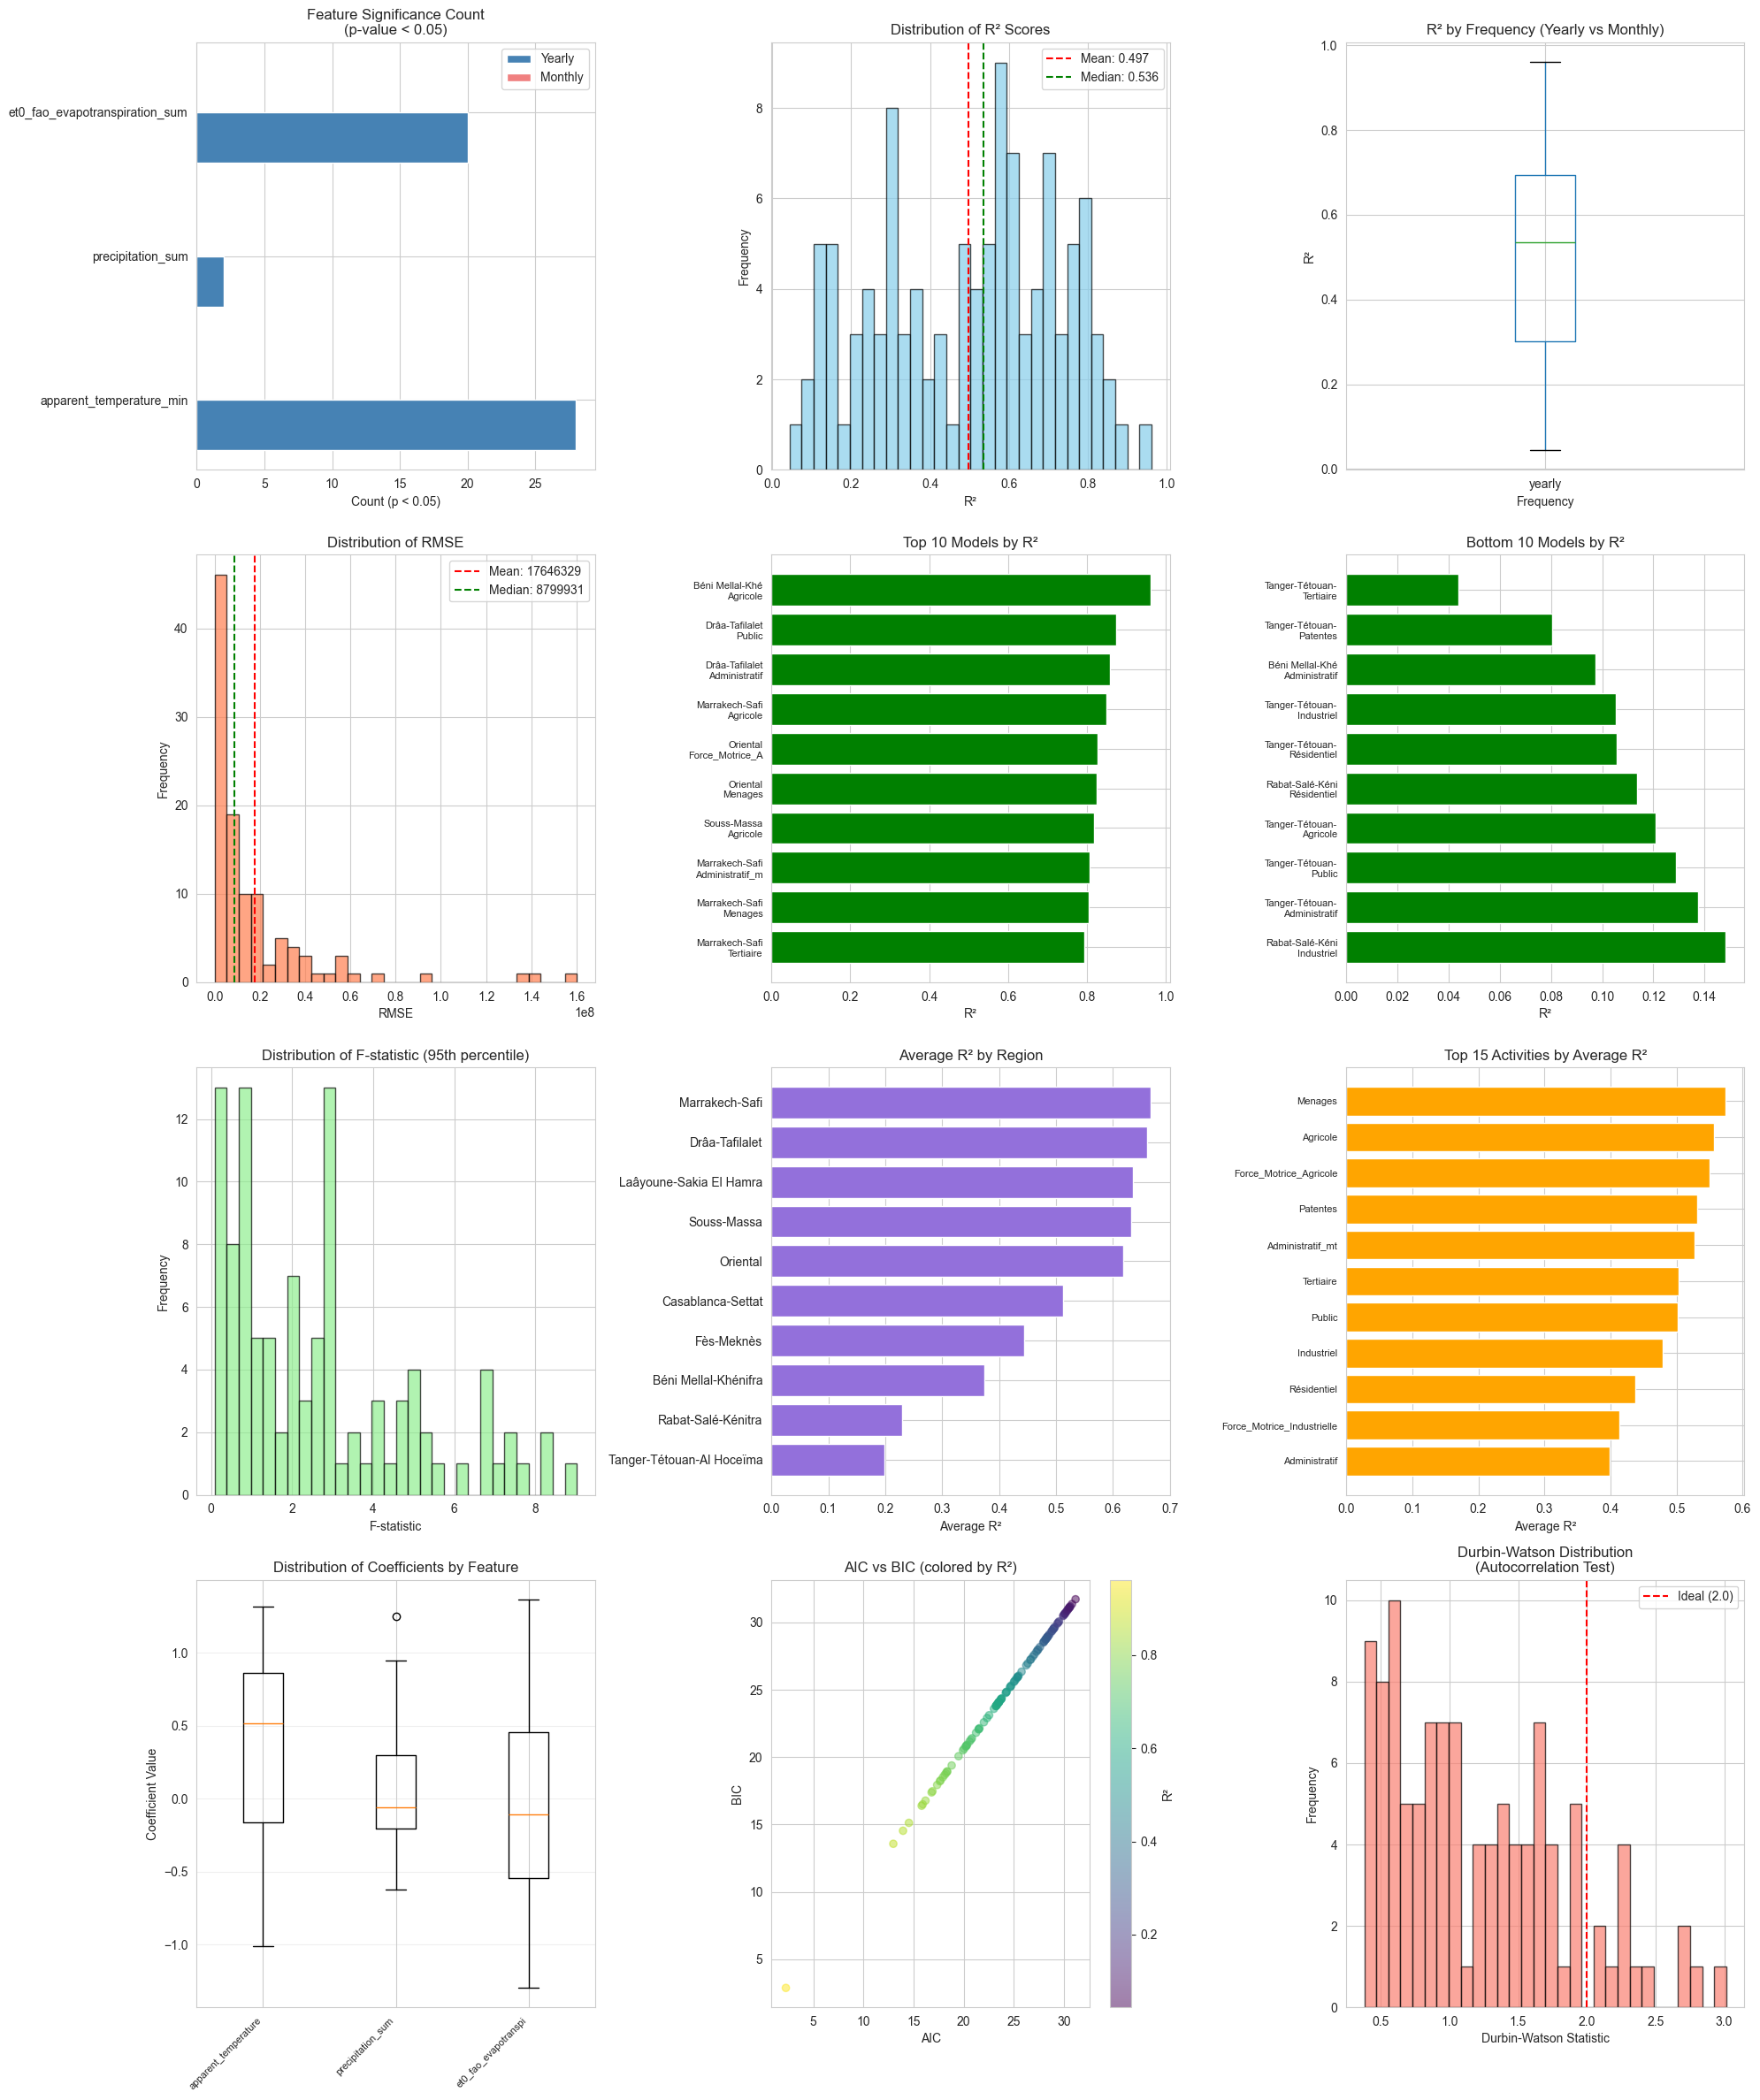

'============================================================\nREGRESSION ANALYSIS SUMMARY REPORT\n============================================================\nTotal Models Analyzed: 110\nYearly Models: 110\nMonthly Models: 0\n\nR² Statistics:\n  Mean: 0.4973\n  Median: 0.5360\n  Std Dev: 0.2301\n  Min: 0.0439\n  Max: 0.9613\n\nModels with R² > 0.7: 26 (23.6%)\nModels with R² > 0.5: 60 (54.5%)\nModels with R² < 0.3: 27 (24.5%)\n\nRMSE Statistics:\n  Mean: 17646328.54\n  Median: 8799931.12\n  Std Dev: 27667842.72\n\nFeature Significance (p < 0.05):\n\n  YEARLY Models:\n    apparent_temperature_min: 28 (25.5%)\n    precipitation_sum: 2 (1.8%)\n    et0_fao_evapotranspiration_sum: 20 (18.2%)\n\n  MONTHLY Models:\n    apparent_temperature_min: 0 (0.0%)\n    precipitation_sum: 0 (0.0%)\n    et0_fao_evapotranspiration_sum: 0 (0.0%)\n\n  OVERALL:\n    apparent_temperature_min: 28 (25.5%)\n    precipitation_sum: 2 (1.8%)\n    et0_fao_evapotranspiration_sum: 20 (18.2%)\n\nTop 5 Best Performing 

In [54]:
# # Create analysis report for Yeo-Johnson results# 
create_analysis_report(
    results_scaled_reduced_features,
    features=features,
    output_folder="outputs_sensibility/outputs_scaled_reduced_features",
    verbose=False,
)

In [74]:
df_output = pd.DataFrame(results_scaled_reduced_features)

In [75]:
coef_cols = [
# 'coef_unscaled_apparent_temperature_max',
'coef_unscaled_apparent_temperature_min',
# 'coef_unscaled_apparent_temperature_mean',
'coef_unscaled_precipitation_sum', 
'coef_unscaled_et0_fao_evapotranspiration_sum'
]

df_output_unscaled = df_output[['Region', 'Activity', 'RMSE', 'MAE', 'R2', 'implicit_intercept'] + coef_cols]
df_output_unscaled.to_csv(PROJECT_ROOT / "outputs_sensibility/outputs_scaled_reduced_features/sensitivity_matrix.csv", index=False, encoding='utf-8-sig')


In [76]:
coefs_cols = [
# 'coef_apparent_temperature_max', 
'coef_apparent_temperature_min', 
# 'coef_apparent_temperature_mean',
'coef_precipitation_sum', 
'coef_et0_fao_evapotranspiration_sum'
]

df_output_scaled = df_output[['Region', 'Activity', 'RMSE', 'MAE', 'R2'] + coefs_cols]

C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3936158483.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(coef_data, labels=[f[:20] for f in feature_names], patch_artist=True)
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3936158483.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['avg_abs_sensitivity'] = df_output[coef_cols].abs().mean(axis=1)
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3936158483.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to

Plot saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_scaled_reduced_features\sensitivity_results_scaled.png


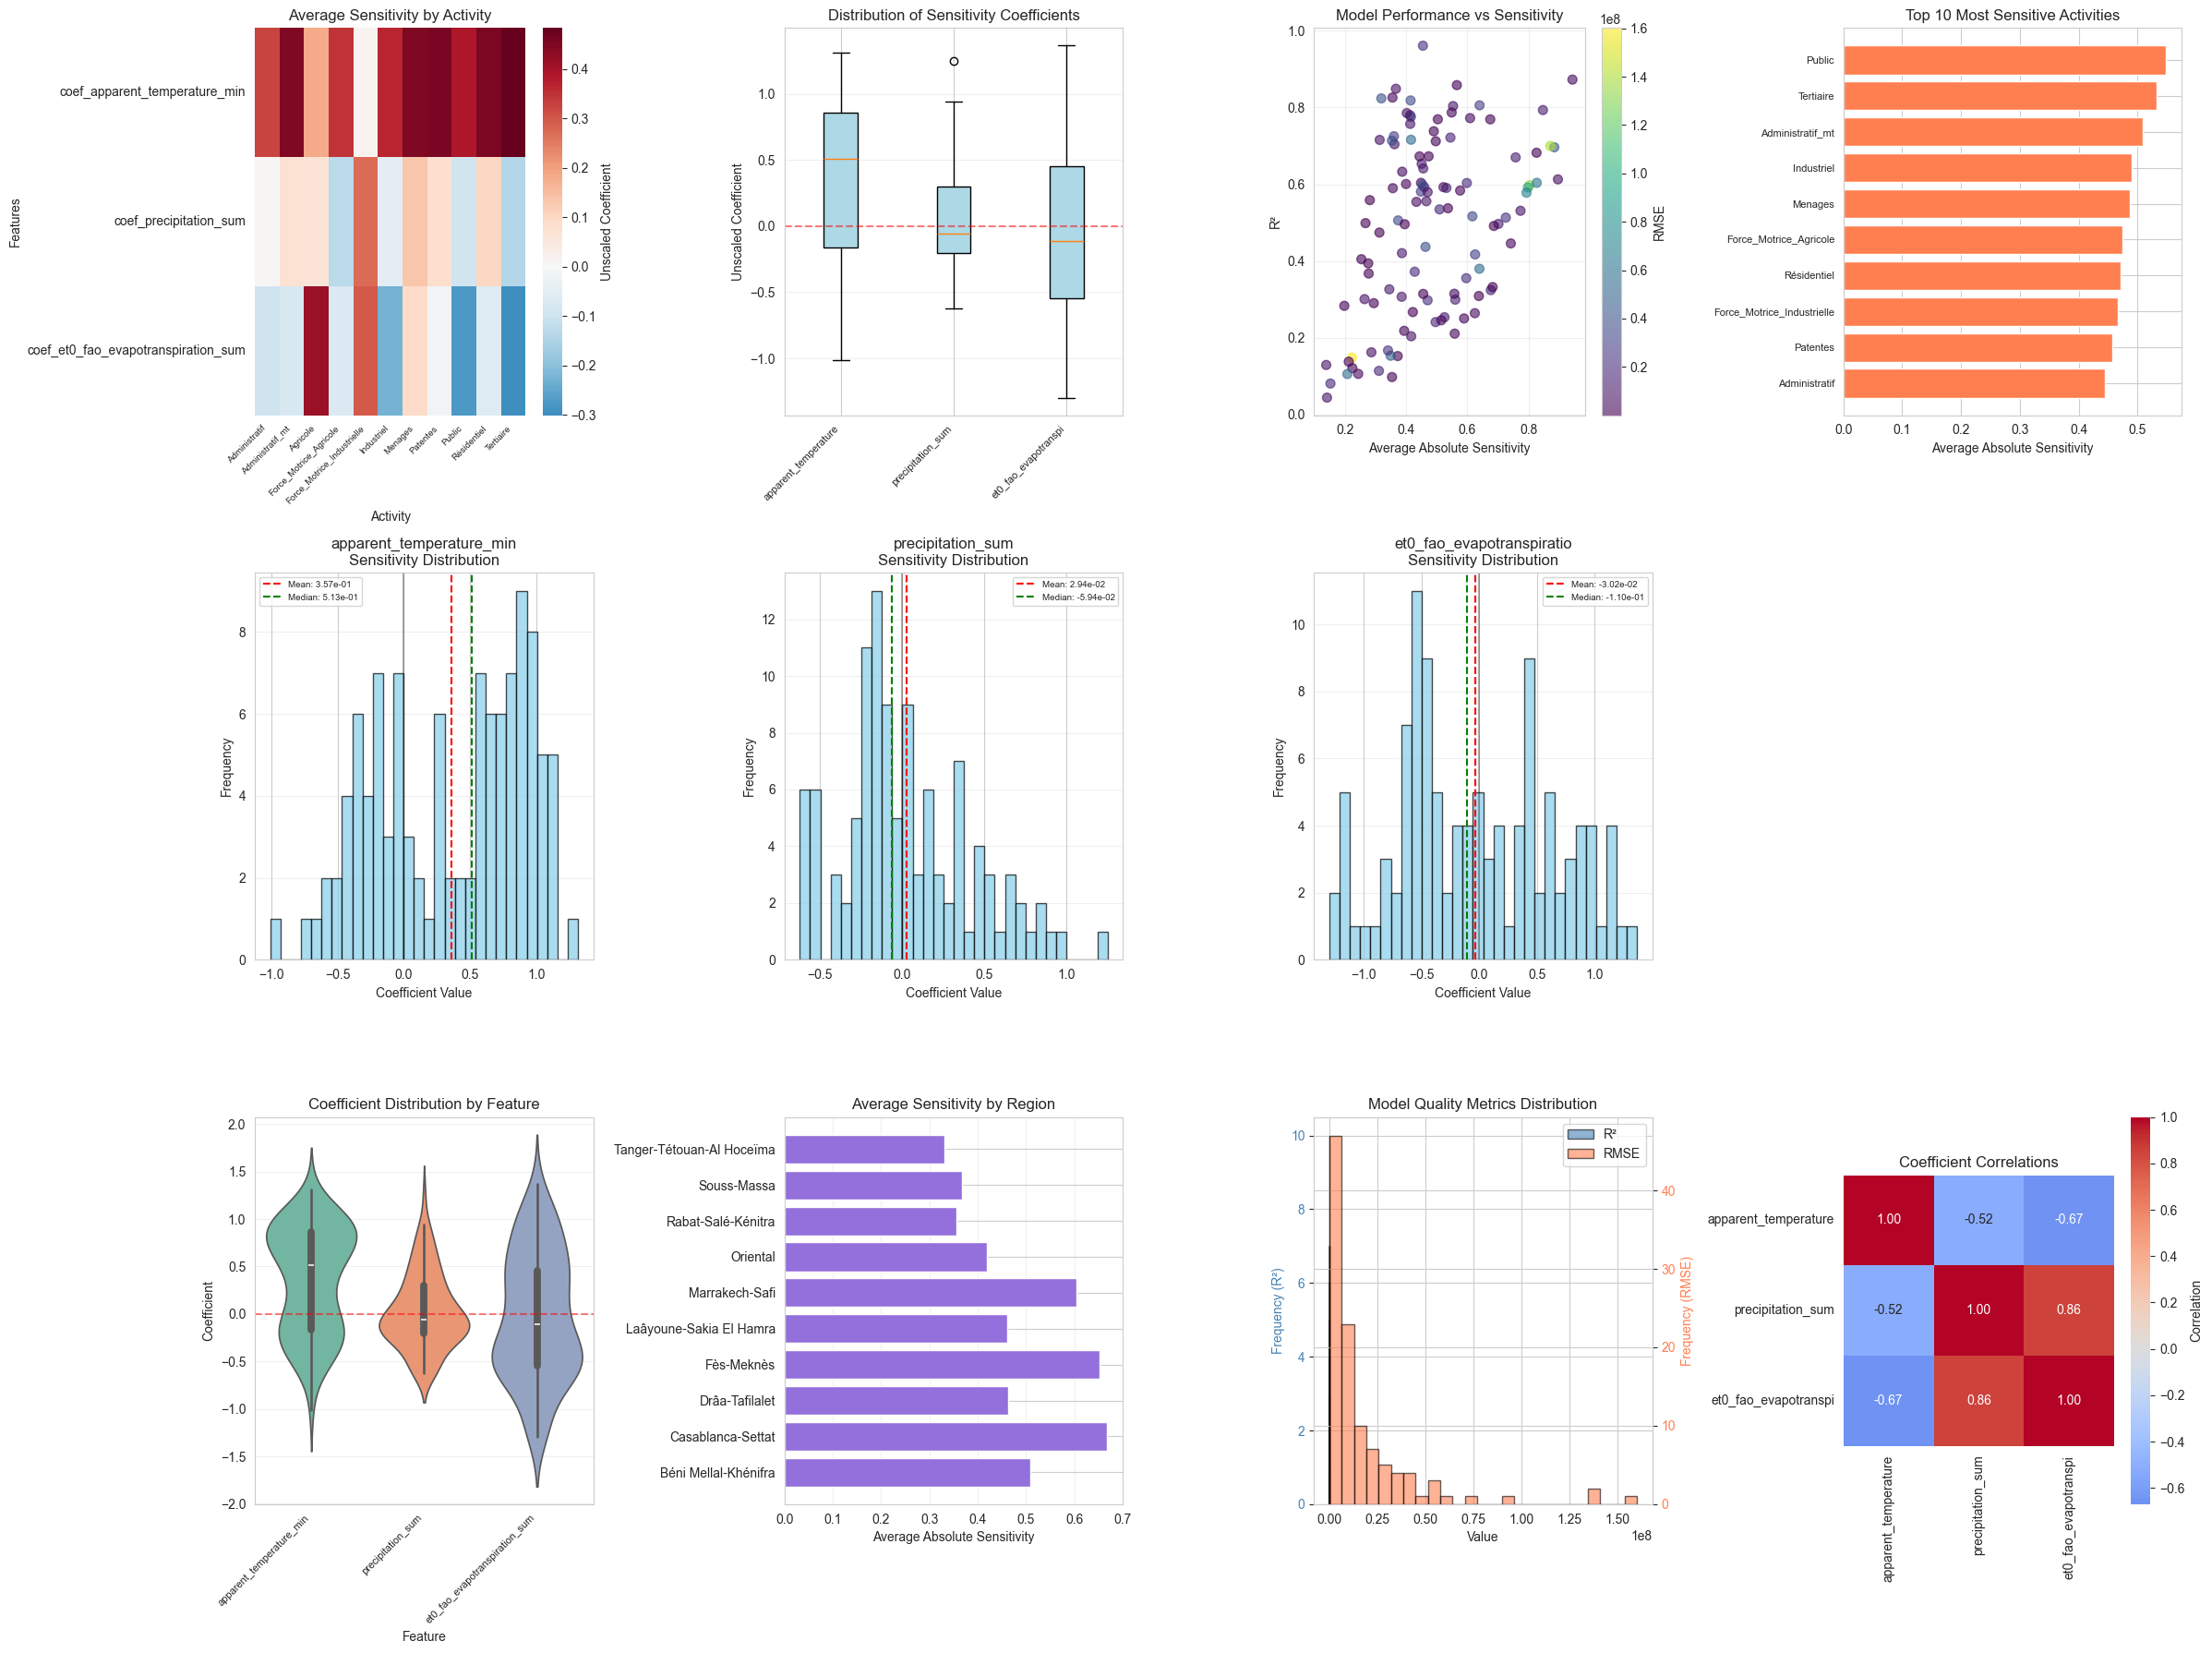


SENSITIVITY ANALYSIS SUMMARY
Total Models: 110

Model Performance:
  R² - Mean: 0.4973, Median: 0.5360
  RMSE - Mean: 17646328.54, Median: 8799931.12
  MAE - Mean: 17646328.54, Median: 8799931.12

Coefficient Statistics:
  apparent_temperature_min:
    Mean: 3.5655e-01, Median: 5.1326e-01, Std: 5.5676e-01
  precipitation_sum:
    Mean: 2.9438e-02, Median: -5.9374e-02, Std: 3.9669e-01
  et0_fao_evapotranspiration_sum:
    Mean: -3.0219e-02, Median: -1.0953e-01, Std: 6.6764e-01


In [77]:
plot_sensitivity_analysis(df_output_scaled, save_path=PROJECT_ROOT / "outputs_sensibility/outputs_scaled_reduced_features/sensitivity_results_scaled.png", prefix = "coef_")

In [78]:
# Prepare data for simulation by merging predictions with meteo data
df_grd_yearly_with_meteo = df_grd_yearly.merge(
    df_meteo_yearly[['Region', 'Year'] + features],
    on=['Region', 'Year'],
    how='left'
)

print(f"Shape before merge: {df_grd_yearly.shape}")
print(f"Shape after merge: {df_grd_yearly_with_meteo.shape}")
print(f"\nColumns: {df_grd_yearly_with_meteo.columns.tolist()}")
print(f"\nNull values after merge:")
print(df_grd_yearly_with_meteo.isnull().sum())

Shape before merge: (1100, 6)
Shape after merge: (1100, 9)

Columns: ['Region', 'Year', 'Class', 'Activity', 'Consommation_Kwh', 'Nbr Clients', 'apparent_temperature_min', 'precipitation_sum', 'et0_fao_evapotranspiration_sum']

Null values after merge:
Region                            0
Year                              0
Class                             0
Activity                          0
Consommation_Kwh                  0
Nbr Clients                       0
apparent_temperature_min          0
precipitation_sum                 0
et0_fao_evapotranspiration_sum    0
dtype: int64



METEOROLOGICAL PREDICTION SUMMARY
Total Predictions: 1100

Prediction Performance:
  RMSE: 18753178.92
  MAE: 8742903.18
  Mean Error: 1618210.89
  Mean Error %: -3.44%

Prediction Analysis:
  Mean Prediction: 128736496.06
  Mean Actual: 130354706.96

Individual Feature Contributions (Mean):
  apparent_temperature_min: 175813589.70
  precipitation_sum: -3084080.50
  et0_fao_evapotranspiration_sum: -104739943.53
  implicit_intercept: 60746930.40

Plot saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_scaled_reduced_features\simulations\meteo_prediction_analysis.png


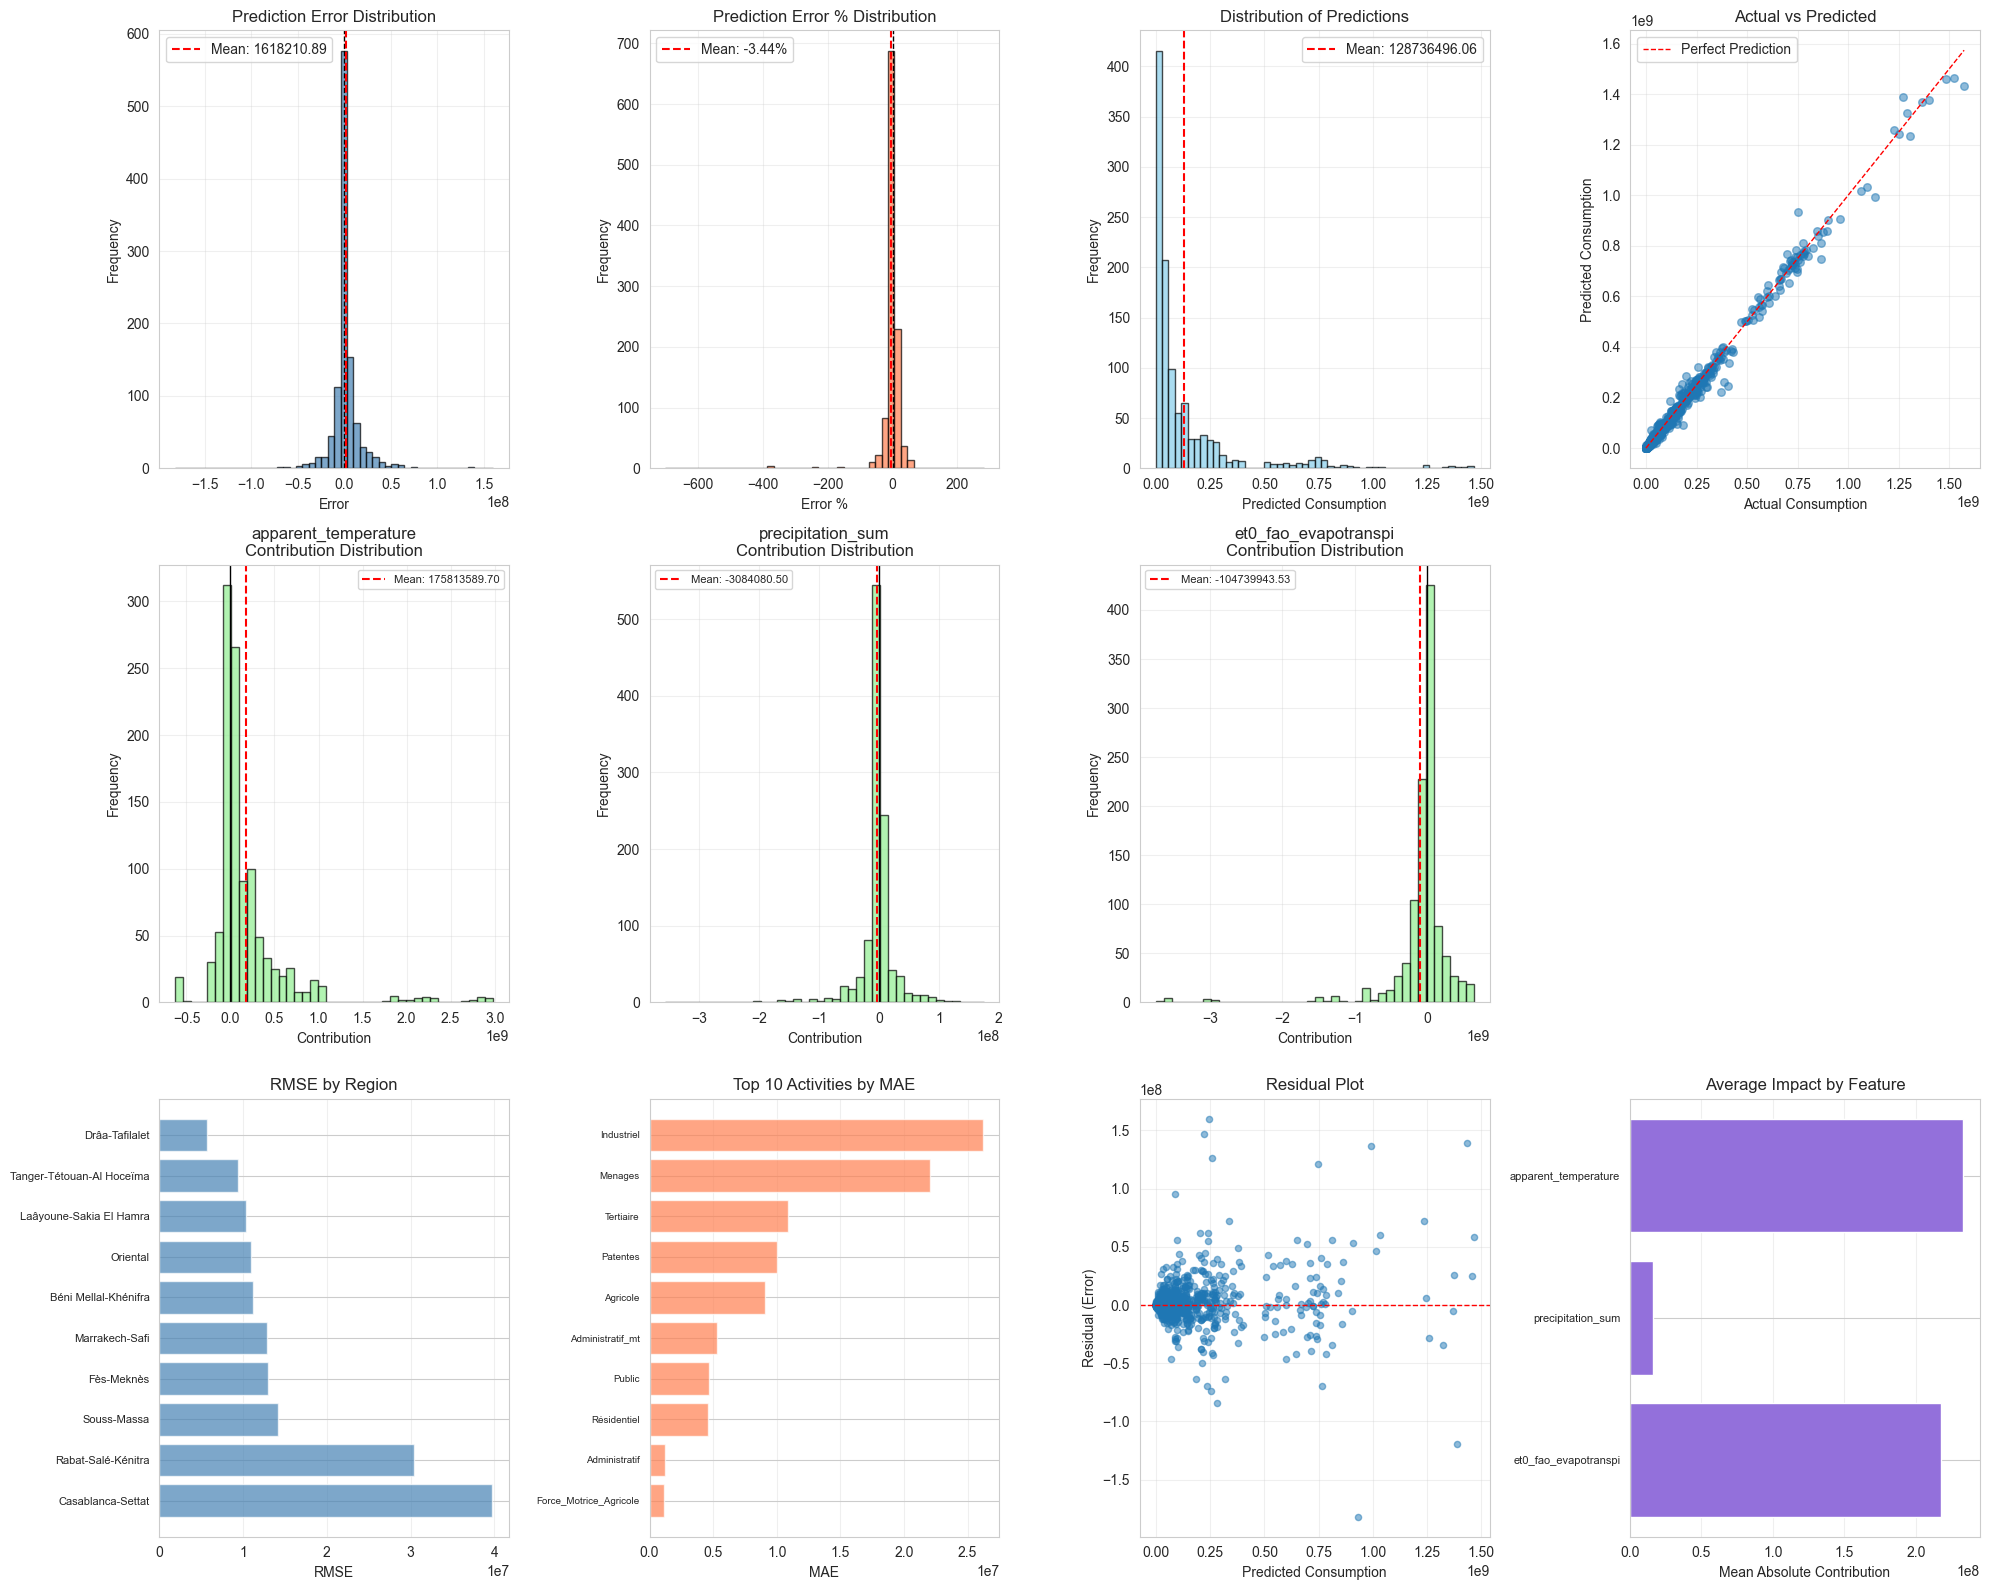

Detailed results saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_scaled_reduced_features\simulations\meteo_prediction_results.xlsx


In [79]:
# Run the simulation
results_simulation = simulate_meteo_corrections_absolute(
    df_predictions=df_grd_yearly_with_meteo,
    df_sensitivity=df_output_unscaled,
    meteo_features=features,
    actual_col='Consommation_Kwh',
    output_folder=PROJECT_ROOT / "outputs_sensibility/outputs_scaled_reduced_features/simulations"
)

# On preds

In [80]:
df_grd_yearly.columns

Index(['Region', 'Year', 'Class', 'Activity', 'Consommation_Kwh',
       'Nbr Clients'],
      dtype='object')

In [81]:
## regex utility to get only files that are like "Béni_Mellal-Khénifra_consommation_kwh_final.xlsx" and extract the region name from them
## it shouldn't match the files starting with monthly_predictions_by_entity_
data = []
root = PROJECT_ROOT / "outputs/finals/stf_srm"
pattern = re.compile(r"^(?!monthly_predictions_by_entity_)(.*?)_consommation_kwh_final\.xlsx$")
for el in os.listdir(root):
    match = pattern.match(el)
    if match:
        region_name = match.group(1)
        temp_data = pd.read_excel(root / el)
        for i in range(11):
            row = temp_data.iloc[i]
            for year in range(2021, 2024):
                out = {
                    "Region": region_name,
                    "Activity": row["Entity"][9:],
                    "Year": year,
                    "Consommation_Kwh": row[f"{year}_actual_annual"],
                    "Predicted_Consommation_Kwh": row[f"{year}_predicted_annual"],
                }
                data.append(out)

In [82]:
df_error = pd.DataFrame(data)

In [83]:
root = PROJECT_ROOT / "outputs/outputs_srm/2017"
data = []
for region_folder in os.listdir(root):
    region_path = root / region_folder
    if region_path.is_dir():
        for el in os.listdir(region_path):
            if el.startswith(region_folder):
                temp_data = pd.read_excel(region_path / el)
                for i in range(11):
                    row = temp_data.iloc[i]
                    for year in range(2015, 2018):
                        out = {
                            "Region": region_folder,
                            "Activity": row["Entity"][9:],
                            "Year": year,
                            "Consommation_Kwh": row[f"{year}_actual_annual"],
                            "Predicted_Consommation_Kwh": row[f"{year}_predicted_annual"],
                        }
                        data.append(out)

In [84]:
df_error = pd.concat([df_error, pd.DataFrame(data)])

In [85]:
df_error["Region"].replace({"Laâyoune-Sakia_El_Hamra": "Laâyoune-Sakia El Hamra", "Tanger-Tétouan-Al_Hoceïma":"Tanger-Tétouan-Al Hoceïma", "Béni_Mellal-Khénifra": "Béni Mellal-Khénifra"}, inplace=True)

C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3108723715.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_error["Region"].replace({"Laâyoune-Sakia_El_Hamra": "Laâyoune-Sakia El Hamra", "Tanger-Tétouan-Al_Hoceïma":"Tanger-Tétouan-Al Hoceïma", "Béni_Mellal-Khénifra": "Béni Mellal-Khénifra"}, inplace=True)


In [86]:
len(df_error)

660

In [87]:
df_error["Activity"].nunique()

11

In [88]:
df_error["Error"] = df_error["Consommation_Kwh"] - df_error["Predicted_Consommation_Kwh"]

In [89]:
df_error.isna().sum()

Region                        0
Activity                      0
Year                          0
Consommation_Kwh              0
Predicted_Consommation_Kwh    0
Error                         0
dtype: int64

<Axes: xlabel='Error', ylabel='Count'>

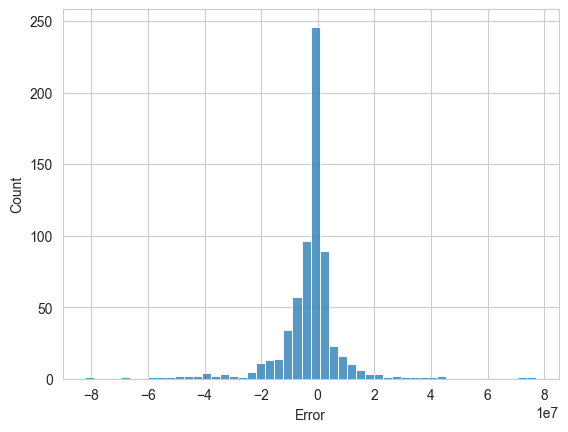

In [90]:
sns.histplot(df_error["Error"], bins=50)

### running

In [91]:
features = [
        # 'apparent_temperature_mean',
        # 'apparent_temperature_max', 
        'apparent_temperature_min',
        'precipitation_sum', 
        'et0_fao_evapotranspiration_sum'
    ]

In [92]:
results_scaled_reduced_features = run_full_analysis(
    df_error,
    None,
    df_meteo_yearly,
    None,
    features=features,
    fit_intercept=False,
    output_folder="outputs_sensibility/outputs_errors_2",
    transformer_x=StandardScaler(),
    transformer_y=StandardScaler(),
    frequencies=["yearly"],
    target = "Error",
    use_lasso=0.2,
    lasso_alpha=1.0
)

Starting analysis for 10 regions and 11 activities...
Frequencies: yearly
Regression Type: Elastic Net (L1_wt=0.2, alpha=1.0)
X Transformer: StandardScaler
Y Transformer: StandardScaler
Processing Yearly data...
Done! Results saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_errors_2\regression_analysis_results.csv
Total records: 110


C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3876949072.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(coef_data, labels=[f[:20] for f in features], vert=True)


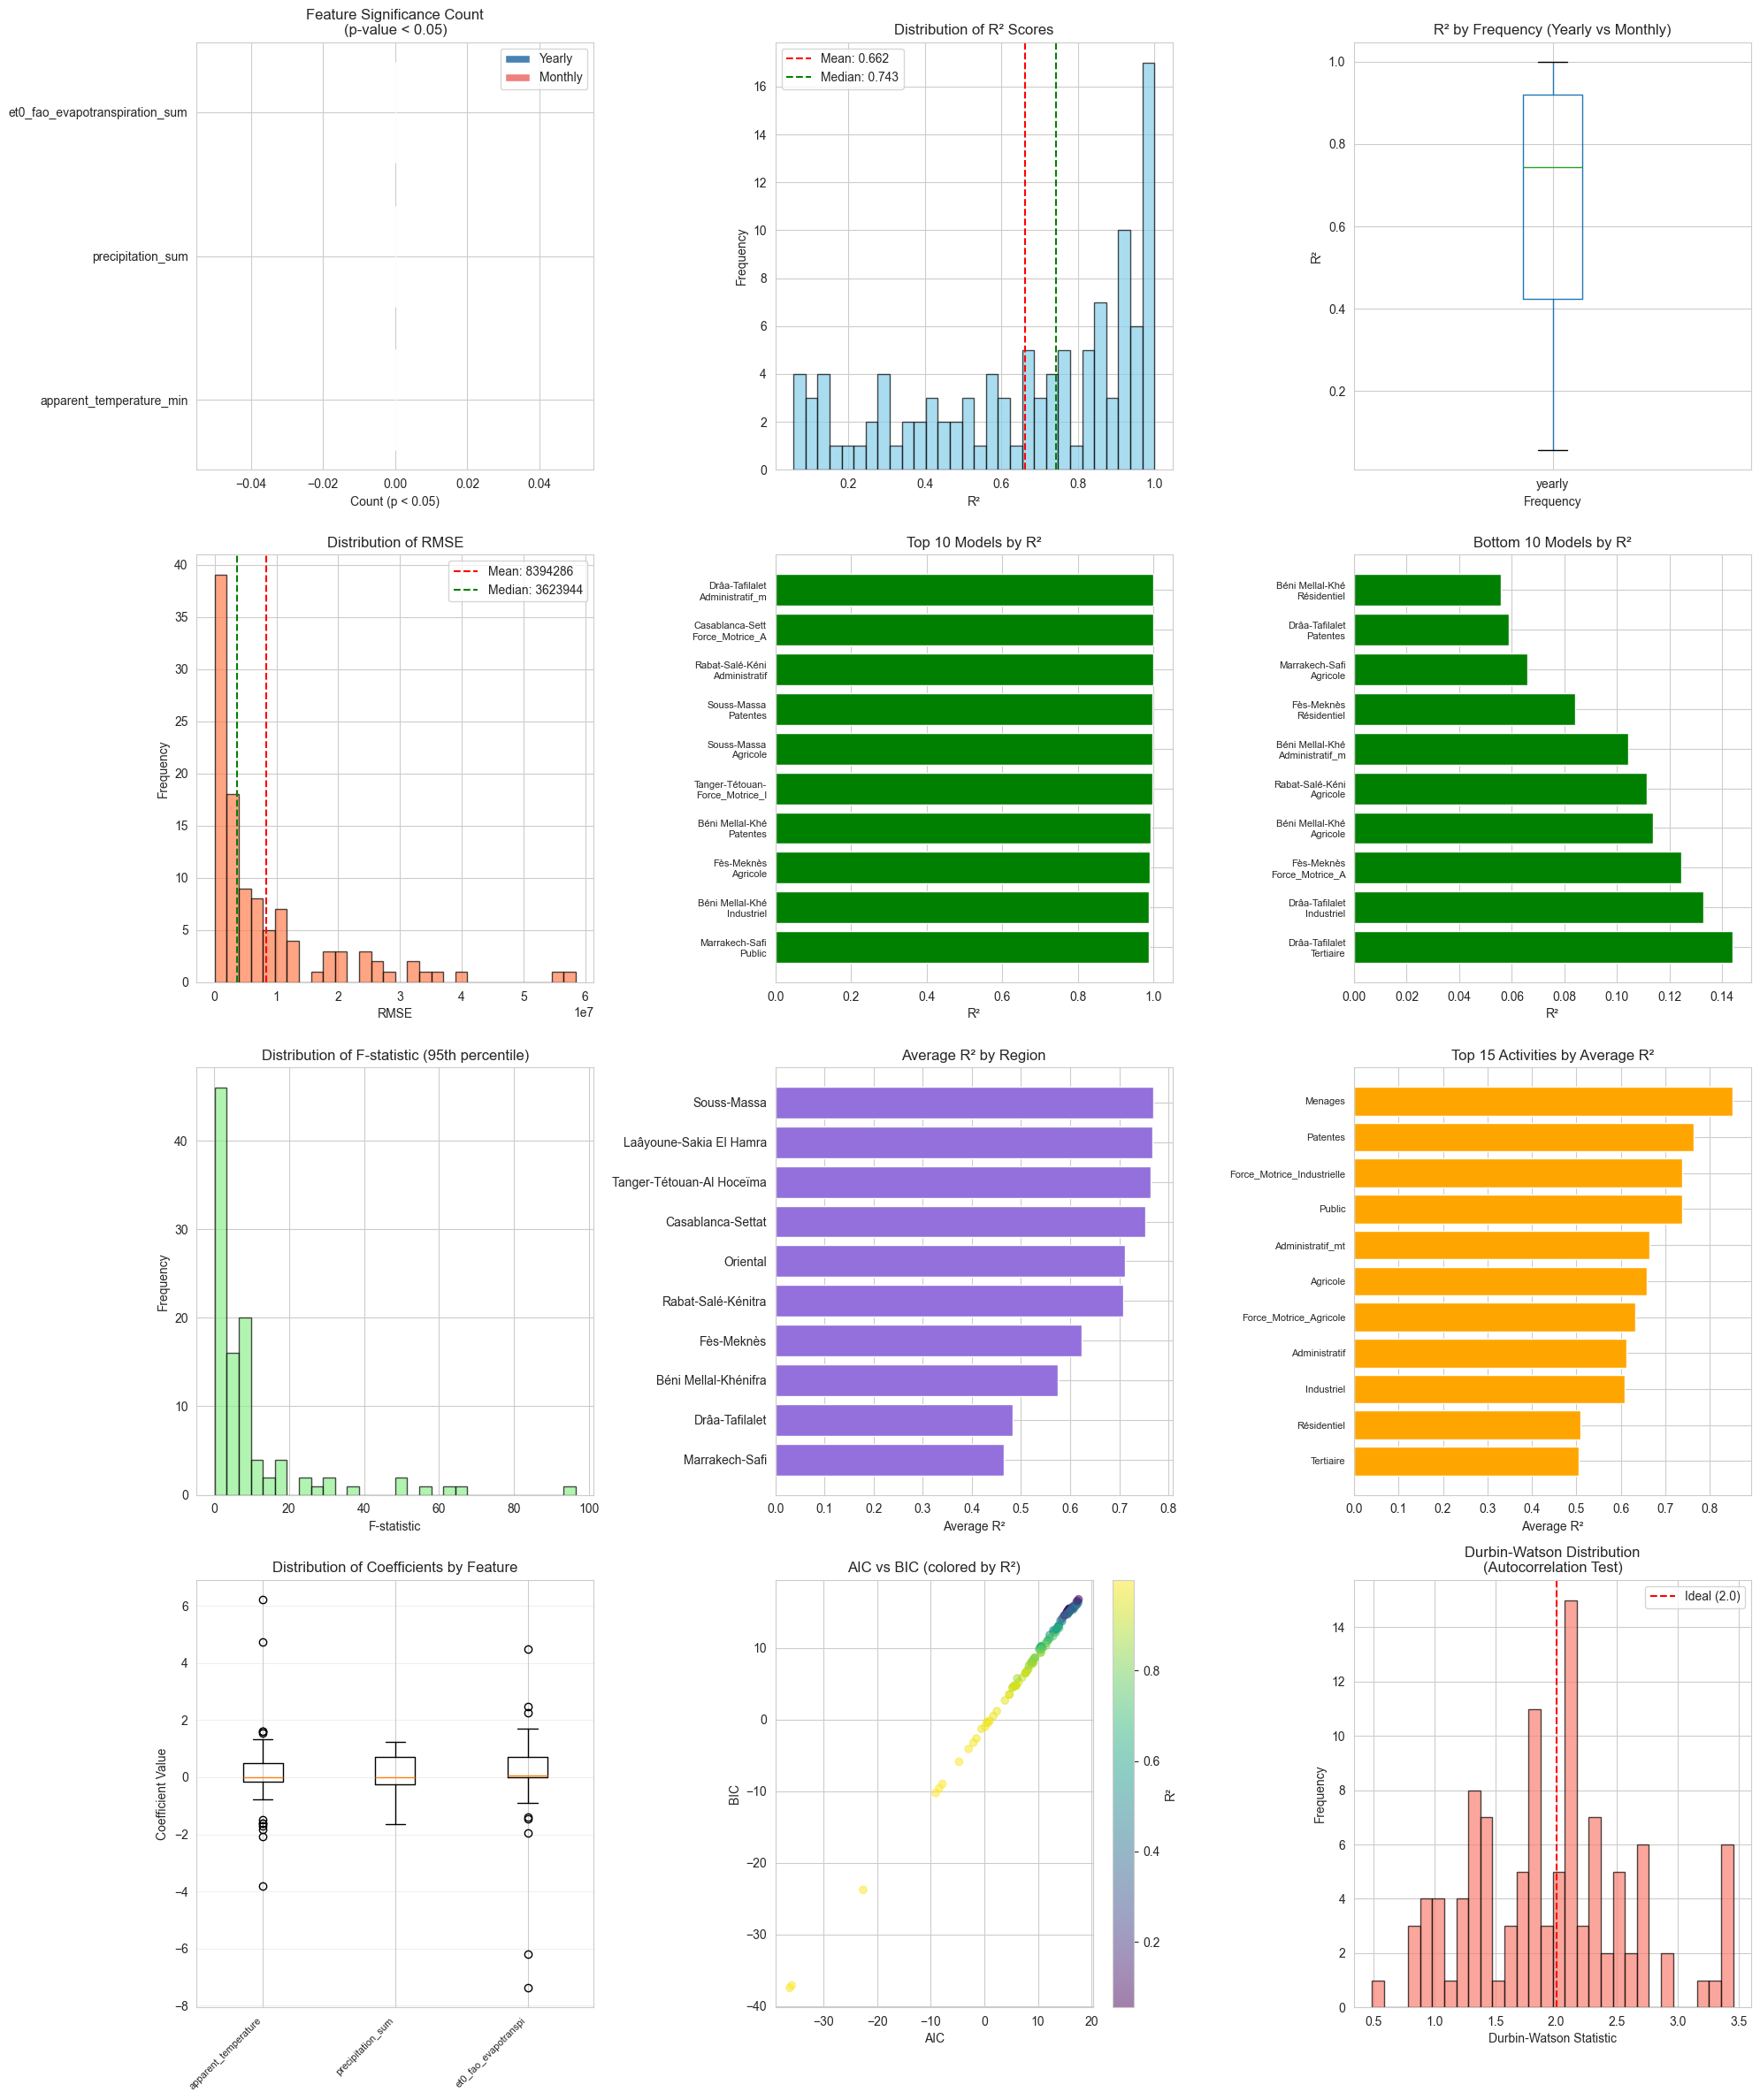

'============================================================\nREGRESSION ANALYSIS SUMMARY REPORT\n============================================================\nTotal Models Analyzed: 110\nYearly Models: 110\nMonthly Models: 0\n\nR² Statistics:\n  Mean: 0.6621\n  Median: 0.7435\n  Std Dev: 0.2943\n  Min: 0.0559\n  Max: 1.0000\n\nModels with R² > 0.7: 59 (53.6%)\nModels with R² > 0.5: 78 (70.9%)\nModels with R² < 0.3: 18 (16.4%)\n\nRMSE Statistics:\n  Mean: 8394285.65\n  Median: 3623944.16\n  Std Dev: 11342622.14\n\nFeature Significance (p < 0.05):\n\n  YEARLY Models:\n    apparent_temperature_min: 0 (0.0%)\n    precipitation_sum: 0 (0.0%)\n    et0_fao_evapotranspiration_sum: 0 (0.0%)\n\n  MONTHLY Models:\n    apparent_temperature_min: 0 (0.0%)\n    precipitation_sum: 0 (0.0%)\n    et0_fao_evapotranspiration_sum: 0 (0.0%)\n\n  OVERALL:\n    apparent_temperature_min: 0 (0.0%)\n    precipitation_sum: 0 (0.0%)\n    et0_fao_evapotranspiration_sum: 0 (0.0%)\n\nTop 5 Best Performing Combinati

In [93]:
# Create analysis report for Yeo-Johnson results
create_analysis_report(
    results_scaled_reduced_features,
    features=features,
    output_folder="outputs_sensibility/outputs_errors_2",
    verbose=False,
)

In [94]:
df_output = pd.DataFrame(results_scaled_reduced_features)

In [95]:
df_output.columns

Index(['Region', 'Activity', 'Frequency', 'Test_Year', 'RMSE', 'MAE', 'R2',
       'Adj_R2', 'F_statistic', 'Prob_F_statistic', 'AIC', 'BIC',
       'Log_Likelihood', 'Condition_Number', 'Durbin_Watson', 'Jarque_Bera',
       'Prob_Jarque_Bera', 'Skew', 'Kurtosis', 'Transformer_Y',
       'Transformer_X', 'Regularization_Type', 'L1_Weight',
       'Regularization_Alpha', 'Coefficients_Stats',
       'coef_apparent_temperature_min',
       'coef_unscaled_apparent_temperature_min',
       'pval_apparent_temperature_min', 'zero_apparent_temperature_min',
       'implicit_intercept', 'coef_precipitation_sum',
       'coef_unscaled_precipitation_sum', 'pval_precipitation_sum',
       'zero_precipitation_sum', 'coef_et0_fao_evapotranspiration_sum',
       'coef_unscaled_et0_fao_evapotranspiration_sum',
       'pval_et0_fao_evapotranspiration_sum',
       'zero_et0_fao_evapotranspiration_sum'],
      dtype='object')

In [96]:
coef_cols = [
# 'coef_unscaled_apparent_temperature_max',
'coef_unscaled_apparent_temperature_min',
# 'coef_unscaled_apparent_temperature_mean',
'coef_unscaled_precipitation_sum', 
'coef_unscaled_et0_fao_evapotranspiration_sum'
]

df_output_unscaled = df_output[['Region', 'Activity', 'RMSE', 'MAE', 'R2', 'implicit_intercept'] + coef_cols]
df_output_unscaled.to_csv(PROJECT_ROOT / "outputs_sensibility/outputs_errors_2/sensitivity_matrix.csv", index=False, encoding='utf-8-sig')


In [97]:
coefs_cols = [
# 'coef_apparent_temperature_max', 
'coef_apparent_temperature_min', 
# 'coef_apparent_temperature_mean',
'coef_precipitation_sum', 
'coef_et0_fao_evapotranspiration_sum'
]

df_output_scaled = df_output[['Region', 'Activity', 'RMSE', 'MAE', 'R2'] + coefs_cols]

In [98]:
df_error["Activity"].unique()

array(['Administratif', 'Administratif_mt', 'Agricole',
       'Force_Motrice_Agricole', 'Force_Motrice_Industrielle',
       'Industriel', 'Menages', 'Patentes', 'Public', 'Résidentiel',
       'Tertiaire'], dtype=object)

C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3936158483.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(coef_data, labels=[f[:20] for f in feature_names], patch_artist=True)
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3936158483.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['avg_abs_sensitivity'] = df_output[coef_cols].abs().mean(axis=1)
C:\Users\Soufiane.AITELAOUAD\AppData\Local\Temp\ipykernel_15840\3936158483.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to

Plot saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_errors_2\sensitivity_results_scaled.png


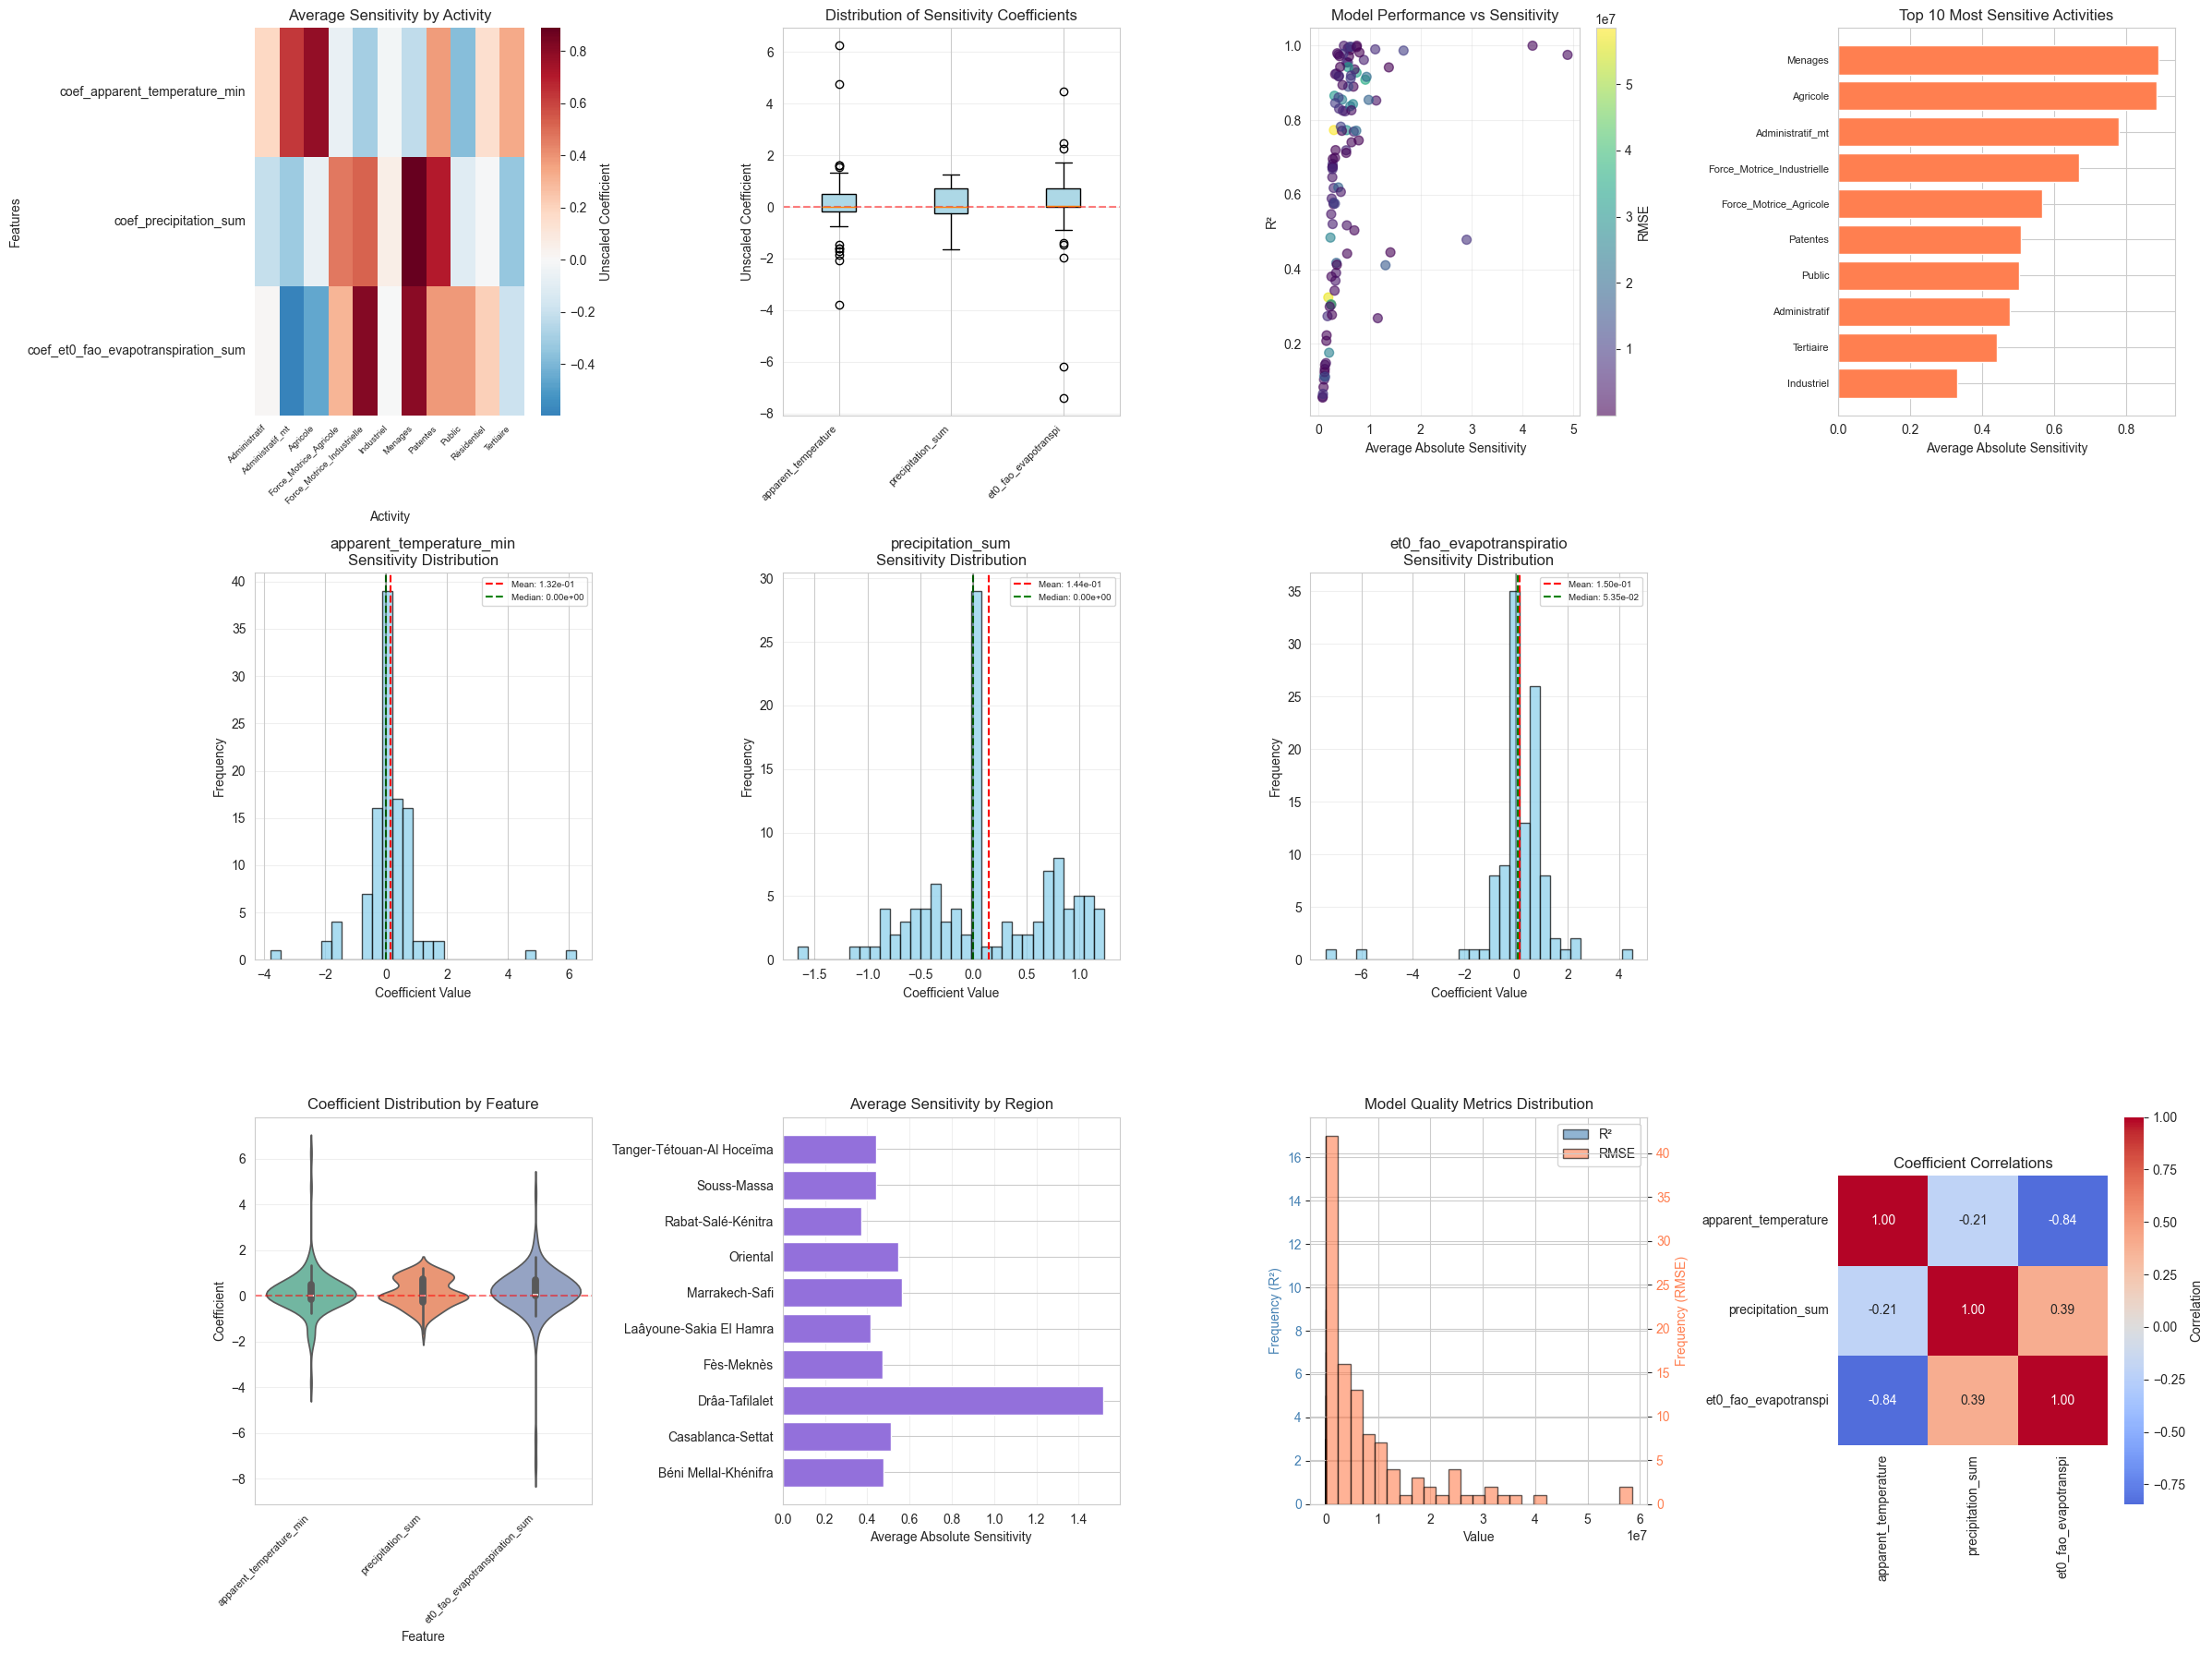


SENSITIVITY ANALYSIS SUMMARY
Total Models: 110

Model Performance:
  R² - Mean: 0.6621, Median: 0.7435
  RMSE - Mean: 8394285.65, Median: 3623944.16
  MAE - Mean: 8394285.65, Median: 3623944.16

Coefficient Statistics:
  apparent_temperature_min:
    Mean: 1.3196e-01, Median: 0.0000e+00, Std: 1.0458e+00
  precipitation_sum:
    Mean: 1.4381e-01, Median: 0.0000e+00, Std: 6.2333e-01
  et0_fao_evapotranspiration_sum:
    Mean: 1.4993e-01, Median: 5.3503e-02, Std: 1.2444e+00


In [99]:
plot_sensitivity_analysis(df_output_scaled, save_path=PROJECT_ROOT / "outputs_sensibility/outputs_errors_2/sensitivity_results_scaled.png", prefix = "coef_")

In [100]:
# Prepare data for simulation by merging predictions with meteo data
df_error_with_meteo = df_error.merge(
    df_meteo_yearly[['Region', 'Year'] + features],
    on=['Region', 'Year'],
    how='left'
)

print(f"Shape before merge: {df_error.shape}")
print(f"Shape after merge: {df_error_with_meteo.shape}")
print(f"\nColumns: {df_error_with_meteo.columns.tolist()}")
print(f"\nNull values after merge:")
print(df_error_with_meteo.isnull().sum())

Shape before merge: (660, 6)
Shape after merge: (660, 9)

Columns: ['Region', 'Activity', 'Year', 'Consommation_Kwh', 'Predicted_Consommation_Kwh', 'Error', 'apparent_temperature_min', 'precipitation_sum', 'et0_fao_evapotranspiration_sum']

Null values after merge:
Region                            0
Activity                          0
Year                              0
Consommation_Kwh                  0
Predicted_Consommation_Kwh        0
Error                             0
apparent_temperature_min          0
precipitation_sum                 0
et0_fao_evapotranspiration_sum    0
dtype: int64



METEOROLOGICAL CORRECTION SIMULATION SUMMARY
Total Predictions: 660

Original Predictions:
  RMSE: 12203869.51
  MAE: 6458100.24
  Mean Error: -2843994.71
  Mean Error %: -3.41%

Corrected Predictions (with meteo adjustment):
  RMSE: 7209598.20
  MAE: 3464004.95
  Mean Error: 511048.40
  Mean Error %: -0.78%

Improvement:
  RMSE Reduction: 40.92%
  MAE Reduction: 46.36%

Meteo Contribution Analysis:
  Mean Meteo Contribution: -3355043.11
  Mean % of Error Explained: 61.88%

Individual Feature Contributions (Mean):
  apparent_temperature_min: 34098410.04
  precipitation_sum: 7739232.34
  et0_fao_evapotranspiration_sum: 32075758.43
  implicit_intercept: -77268443.93

Plot saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_errors_2\simulations\meteo_correction_simulation.png


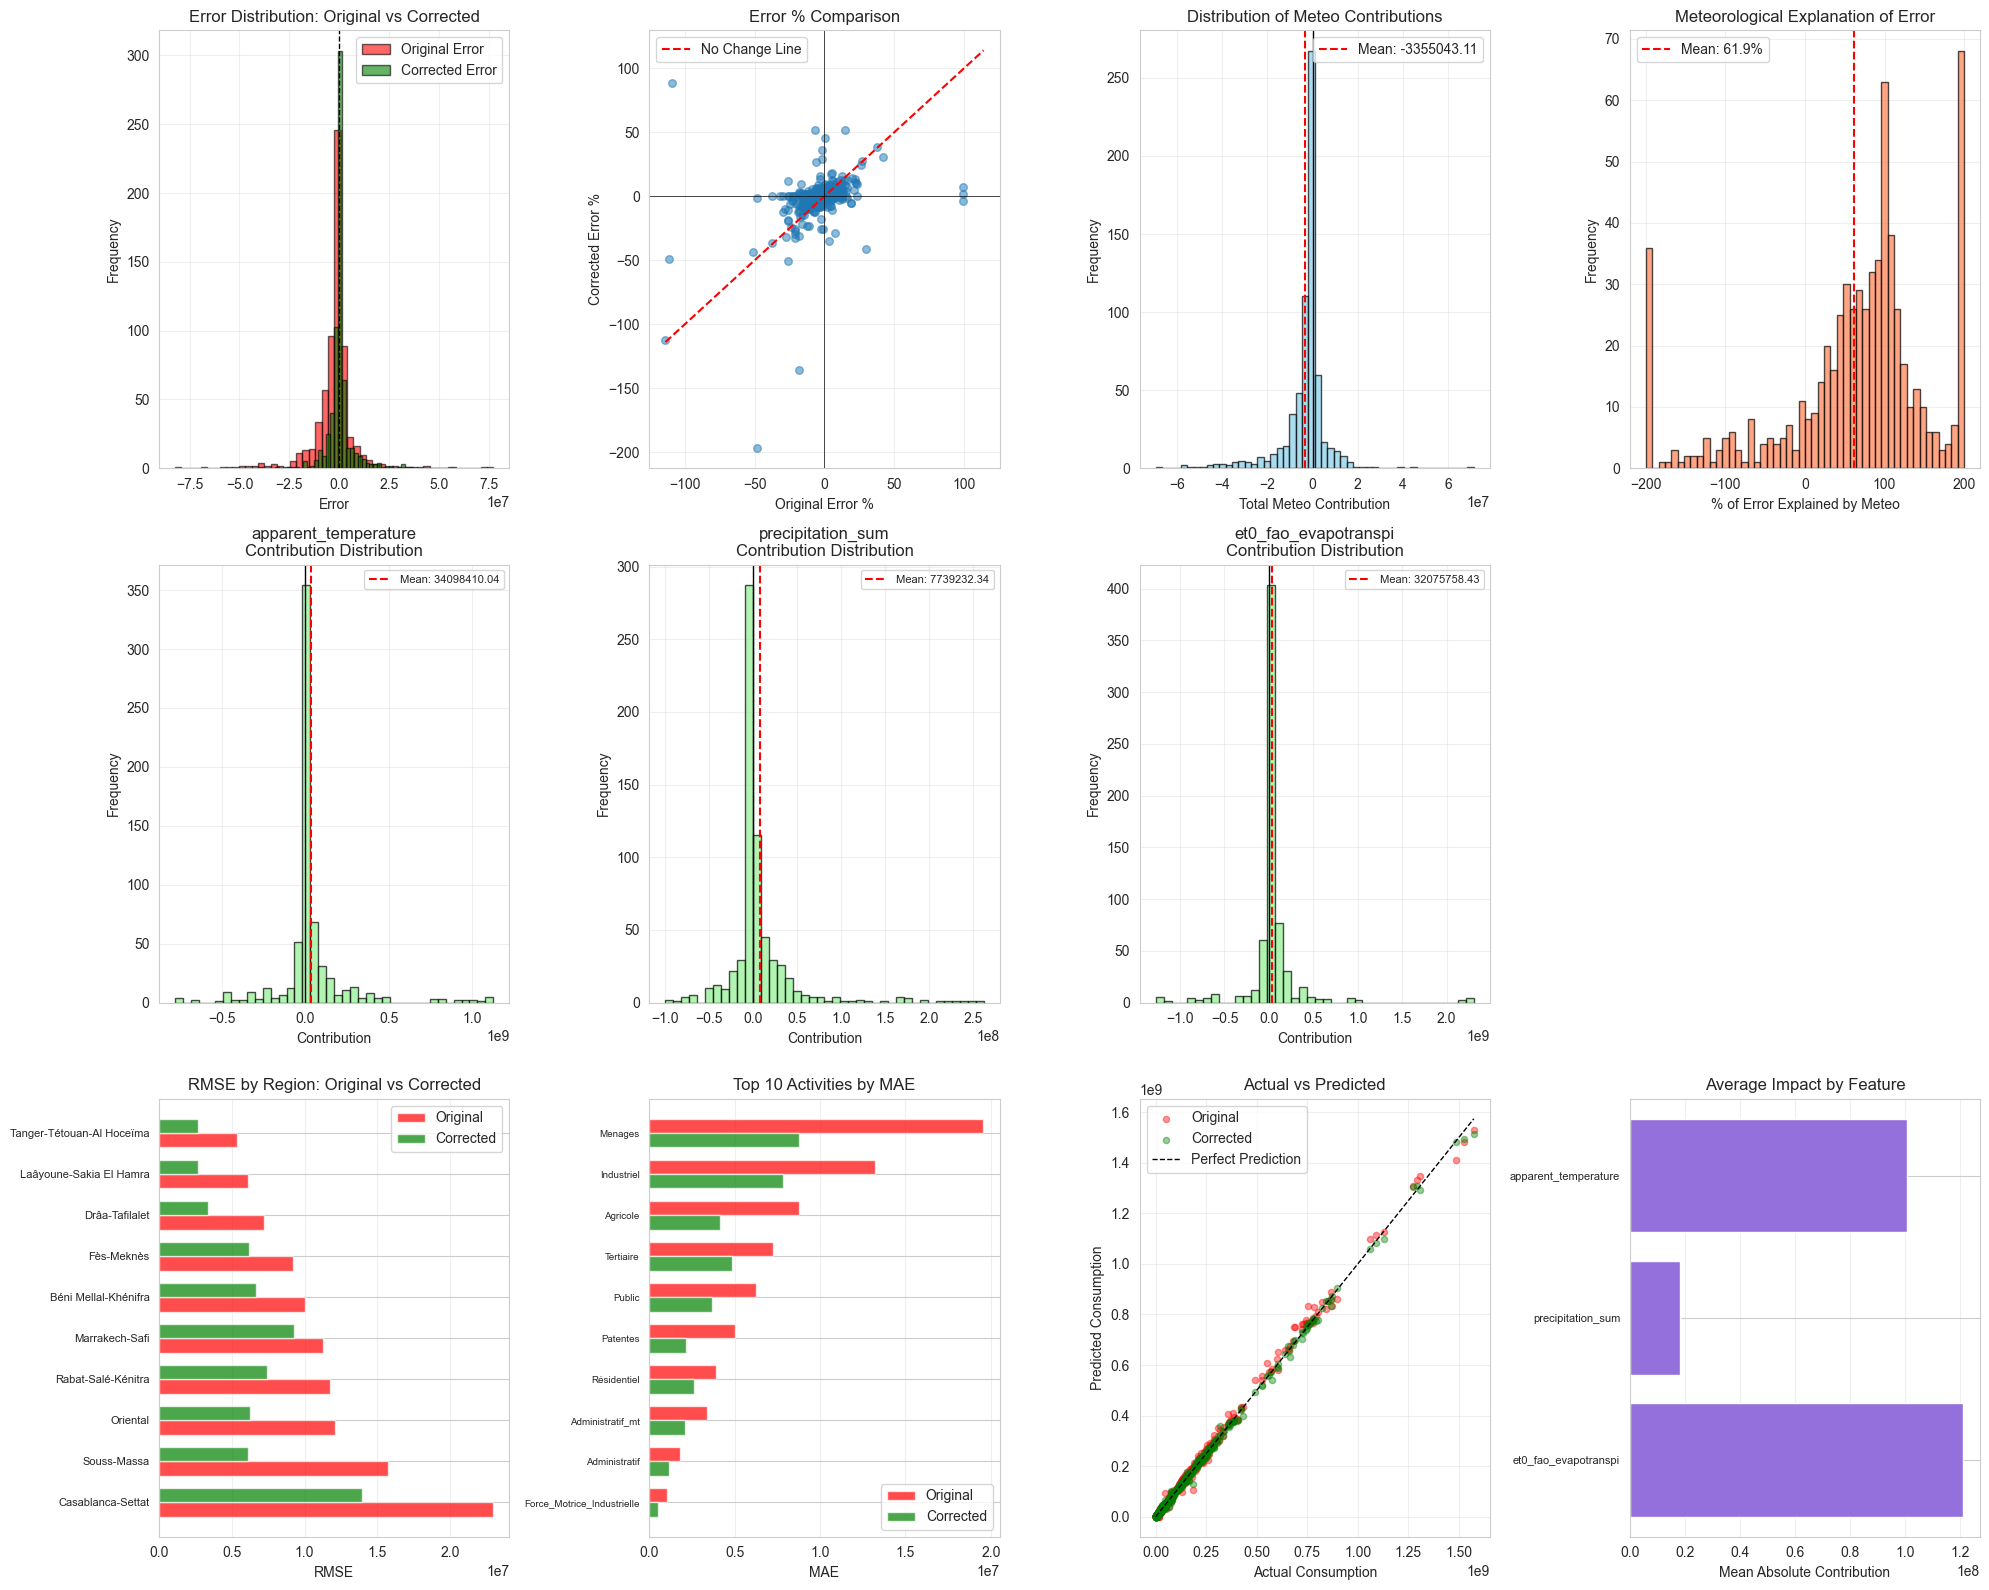

Detailed results saved to: C:\Users\Soufiane.AITELAOUAD\dev.cleverlytics\onee\outputs_sensibility\outputs_errors_2\simulations\meteo_correction_results.xlsx


In [101]:
# Run the simulation
results_simulation = simulate_meteo_corrections(
    df_predictions=df_error_with_meteo,
    df_sensitivity=df_output_unscaled,
    meteo_features=features,
    actual_col='Consommation_Kwh',
    predicted_col='Predicted_Consommation_Kwh',
    output_folder=PROJECT_ROOT / "outputs_sensibility/outputs_errors_2/simulations"
)